In [1]:
!git clone https://github.com/ThriveInternship/Thrive_Internship_ML_A.git
%cd Thrive_Internship_ML_A
!git checkout group-c

Cloning into 'Thrive_Internship_ML_A'...
remote: Enumerating objects: 1001, done.
remote: Counting objects: 100% (320/320), done.
remote: Compressing objects: 100% (167/167), done.
remote: Total 1001 (delta 198), reused 218 (delta 153), pack-reused 681 (from 2)
Receiving objects: 100% (1001/1001), 2.69 MiB | 5.78 MiB/s, done.
Resolving deltas: 100% (403/403), done.
/content/Thrive_Internship_ML_A
Branch 'group-c' set up to track remote branch 'group-c' from 'origin'.
Switched to a new branch 'group-c'


In [ ]:
# Colab detection and base path configuration
import sys, os
from pathlib import Path

IN_COLAB = 'google.colab' in sys.modules
print(f"Environment: {'Google Colab' if IN_COLAB else 'VSCode/Local'}")

if IN_COLAB:
    BASE_PATH = '/content/Thrive_Internship_ML_A'
    DATA_PATH = '/content/Thrive_Internship_ML_A/data/customer_support_tickets_dirty.csv'
    # Use repo directories first, create in /content if needed
    MODEL_DIR = '/content/Thrive_Internship_ML_A/distilbert_ticket_classifier_model'
    APP_FILE = '/content/Thrive_Internship_ML_A/api/app1.py'  # Use repo location
    HTML_FILE = '/content/Thrive_Internship_ML_A/api/ClassifAI.html'  # Use repo location
    REQUIREMENTS_FILE = '/content/Thrive_Internship_ML_A/requirements.txt'
else:
    # Local/VSCode: use repo structure directly
    BASE_PATH = os.path.abspath(os.path.join(os.getcwd(), '..'))
    # Handle case where we're in notebooks/ subdirectory
    if not os.path.exists(os.path.join(BASE_PATH, 'api')):
        BASE_PATH = os.path.dirname(os.path.dirname(os.path.abspath(__file__)))
    # If still not found, assume we're at the repo root
    if not os.path.exists(os.path.join(BASE_PATH, 'api')):
        BASE_PATH = os.getcwd()
    
    DATA_PATH = os.path.join(BASE_PATH, 'data', 'customer_support_tickets_dirty.csv')
    MODEL_DIR = os.path.join(BASE_PATH, 'artifacts', 'models', 'distilbert', 'final')
    # Use api/app1.py from repo directly
    APP_FILE = os.path.join(BASE_PATH, 'api', 'app1.py')
    HTML_FILE = os.path.join(BASE_PATH, 'api', 'ClassifAI.html')
    REQUIREMENTS_FILE = os.path.join(BASE_PATH, 'requirements.txt')

print('BASE_PATH =', BASE_PATH)
print('DATA_PATH =', DATA_PATH)
print('MODEL_DIR =', MODEL_DIR)
print('APP_FILE =', APP_FILE)
print('HTML_FILE =', HTML_FILE)
print('REQUIREMENTS_FILE =', REQUIREMENTS_FILE)

# Verify that repo files exist
print('\n--- File Availability Check ---')
print(f"app1.py exists: {os.path.exists(APP_FILE)}")
print(f"ClassifAI.html exists: {os.path.exists(HTML_FILE)}")
print(f"requirements.txt exists: {os.path.exists(REQUIREMENTS_FILE)}")

# Ensure content folders exist in Colab
if IN_COLAB:
    os.makedirs(os.path.dirname(APP_FILE), exist_ok=True)
    os.makedirs(os.path.dirname(HTML_FILE), exist_ok=True)
    os.makedirs(os.path.join(BASE_PATH, 'data', 'clean'), exist_ok=True)
    os.makedirs(MODEL_DIR, exist_ok=True)


Environment: Google Colab
BASE_PATH = /content/Thrive_Internship_ML_A
DATA_PATH = /content/Thrive_Internship_ML_A/data/customer_support_tickets_dirty.csv
MODEL_DIR = /content/Thrive_Internship_ML_A/distilbert_ticket_classifier_model
APP_FILE = /content/Thrive_Internship_ML_A/app1.py
HTML_FILE = /content/Thrive_Internship_ML_A/ClassifAI.html
REQUIREMENTS_FILE = /content/Thrive_Internship_ML_A/requirements.txt


In [3]:
#  Robust Drive mount helper for Colab — tries auth, retries on common errors, falls back to shared-link/manual upload
DRIVE_MOUNTED = False
DRIVE_PATH = None
if IN_COLAB:
    try:
        from google.colab import auth, drive
        print('Attempting programmatic auth...')
        auth.authenticate_user()
        try:
            drive.flush_and_unmount()
        except Exception:
            pass
        # Attempt mount with force_remount to avoid stale mounts
        drive.mount('/content/drive', force_remount=True)
        DRIVE_MOUNTED = True
        DRIVE_PATH = '/content/drive/My Drive'
        print('✓ Google Drive mounted at', DRIVE_PATH)
    except Exception as e:
        print('⚠️ Drive mount failed:', e)
        print('Falling back to shared-link/manual upload approach — see next cells')
        DRIVE_MOUNTED = False
        DRIVE_PATH = None
else:
    DRIVE_MOUNTED = False
    DRIVE_PATH = BASE_PATH

# Expose DRIVE_MOUNTED and DRIVE_PATH for downstream cells
print('DRIVE_MOUNTED =', DRIVE_MOUNTED)
print('DRIVE_PATH =', DRIVE_PATH)


Attempting programmatic auth...
⚠️ Drive mount failed: Error: credential propagation was unsuccessful
Falling back to shared-link/manual upload approach — see next cells
DRIVE_MOUNTED = False
DRIVE_PATH = None


In [4]:
# Install runtime dependencies when running in Colab (idempotent, quiet installs)
import sys, subprocess
if IN_COLAB:
    pkgs = [
        'gdown',
        'transformers==4.30.0',
        'torch',
        'gradio',
        'scikit-learn',
        'pandas',
        'tqdm',
        'mlflow',
        'fastapi',
        'uvicorn[standard]'
    ]
    for p in pkgs:
        try:
            subprocess.check_call([sys.executable, '-m', 'pip', 'install', '-q', p])
        except Exception as e:
            print('Install failed for', p, e)
print('Dependency install step complete (or skipped in local mode)')


Install failed for transformers==4.30.0 Command '['/usr/bin/python3', '-m', 'pip', 'install', '-q', 'transformers==4.30.0']' returned non-zero exit status 1.
Dependency install step complete (or skipped in local mode)


In [ ]:
# Smart file handler: Use repo files first, download only if missing
import os, re, shutil
from pathlib import Path

def _extract_drive_id(link: str):
    """Extract Google Drive file/folder ID from share link"""
    s = (link or '').strip()
    # Common file patterns: /d/FILE_ID or id=FILE_ID
    m = re.search(r'/d/([a-zA-Z0-9_-]+)', s)
    if m:
        return m.group(1)
    m = re.search(r'id=([a-zA-Z0-9_-]+)', s)
    if m:
        return m.group(1)
    # Folder pattern: /folders/FOLDER_ID
    m = re.search(r'/folders/([a-zA-Z0-9_-]+)', s)
    if m:
        return m.group(1)
    # Fallback: last path segment that looks like an id
    m = re.search(r'([a-zA-Z0-9_-]{10,})$', s)
    if m:
        return m.group(1)
    return None

def _download_drive_file(link: str, out_path: str):
    """Download file/folder from Google Drive using gdown"""
    try:
        import gdown
    except Exception:
        import subprocess, sys
        subprocess.check_call([sys.executable, '-m', 'pip', 'install', '-q', 'gdown'])
        import gdown
    fid = _extract_drive_id(link)
    if not fid:
        raise ValueError('Could not parse Drive id from link: ' + str(link))

    # If the original link looks like a folder (contains '/folders/'), use gdown.download_folder
    if '/folders/' in (link or '') or 'drive/folders' in (link or ''):
        folder_url = f'https://drive.google.com/drive/folders/{fid}'
        # gdown.download_folder expects an output directory; ensure out_path is a directory
        out_dir = out_path
        try:
            os.makedirs(out_dir, exist_ok=True)
        except Exception:
            pass
        print(f"Downloading Drive folder {folder_url} to {out_dir} (this may take a while)...")
        try:
            gdown.download_folder(folder_url, output=out_dir, quiet=False, use_cookies=False)
        except Exception as e:
            # Older versions or different environments may need the url directly
            print('gdown.download_folder failed, attempting fallback via direct uc?id URL for files in folder:', e)
            raise
    else:
        # Regular file download
        url = f'https://drive.google.com/uc?id={fid}'
        print(f"Downloading Drive file {url} to {out_path}...")
        gdown.download(url, out_path, quiet=False)

# Define repo source locations (in case we're cloning and files are available in the repo)
REPO_BASE = BASE_PATH  # BASE_PATH is set in the previous cell
APP_REPO_PATH = os.path.join(REPO_BASE, 'api', 'app1.py')
HTML_REPO_PATH = os.path.join(REPO_BASE, 'api', 'ClassifAI.html')
REQ_REPO_PATH = os.path.join(REPO_BASE, 'requirements.txt')

# Optional: Set shared-link downloads only if repo files are not available
# (In Colab, if the repo is cloned, these should already exist)
MODEL_SHARED_LINK = None  # Model files are downloaded separately in the notebook
APP_SHARED_LINK = None    # Use repo file: api/app1.py
HTML_SHARED_LINK = None   # Use repo file: api/ClassifAI.html
REQ_SHARED_LINK = None    # Use repo file: requirements.txt

print('--- Smart File Acquisition ---')
print(f'Checking for files in repo...')
print(f'app1.py repo location: {APP_REPO_PATH} (exists: {os.path.exists(APP_REPO_PATH)})')
print(f'ClassifAI.html repo location: {HTML_REPO_PATH} (exists: {os.path.exists(HTML_REPO_PATH)})')
print(f'requirements.txt repo location: {REQ_REPO_PATH} (exists: {os.path.exists(REQ_REPO_PATH)})')

if IN_COLAB:
    # For requirements.txt: copy from repo if it exists, otherwise download
    if os.path.exists(REQ_REPO_PATH) and REQ_REPO_PATH != REQUIREMENTS_FILE:
        print(f'✓ Copying requirements.txt from repo to {REQUIREMENTS_FILE}')
        shutil.copy(REQ_REPO_PATH, REQUIREMENTS_FILE)
    elif not os.path.exists(REQUIREMENTS_FILE) and REQ_SHARED_LINK:
        print(f'! requirements.txt not in repo, attempting download from shared link')
        try:
            _download_drive_file(REQ_SHARED_LINK, REQUIREMENTS_FILE)
            print('✓ Downloaded requirements.txt')
        except Exception as e:
            print(f'⚠️  req download failed: {e}')
    else:
        print(f'✓ requirements.txt already available at {REQUIREMENTS_FILE}')
    
    # For app1.py: copy from repo if it exists, otherwise download
    if os.path.exists(APP_REPO_PATH) and APP_REPO_PATH != APP_FILE:
        print(f'✓ Copying app1.py from repo to {APP_FILE}')
        shutil.copy(APP_REPO_PATH, APP_FILE)
    elif not os.path.exists(APP_FILE) and APP_SHARED_LINK:
        print(f'! app1.py not in repo, attempting download from shared link')
        try:
            _download_drive_file(APP_SHARED_LINK, APP_FILE)
            print('✓ Downloaded app1.py')
        except Exception as e:
            print(f'⚠️  app download failed: {e}')
    else:
        print(f'✓ app1.py already available at {APP_FILE}')
    
    # For ClassifAI.html: copy from repo if it exists, otherwise download
    if os.path.exists(HTML_REPO_PATH) and HTML_REPO_PATH != HTML_FILE:
        print(f'✓ Copying ClassifAI.html from repo to {HTML_FILE}')
        shutil.copy(HTML_REPO_PATH, HTML_FILE)
    elif not os.path.exists(HTML_FILE) and HTML_SHARED_LINK:
        print(f'! ClassifAI.html not in repo, attempting download from shared link')
        try:
            _download_drive_file(HTML_SHARED_LINK, HTML_FILE)
            print('✓ Downloaded ClassifAI.html')
        except Exception as e:
            print(f'⚠️  HTML download failed: {e}')
    else:
        print(f'✓ ClassifAI.html already available at {HTML_FILE}')
    
    # Verify all required files are now available
    print('\n--- File Availability After Acquisition ---')
    print(f'app1.py exists: {os.path.exists(APP_FILE)}')
    print(f'ClassifAI.html exists: {os.path.exists(HTML_FILE)}')
    print(f'requirements.txt exists: {os.path.exists(REQUIREMENTS_FILE)}')
    
    # Fallback: manual upload if critical files still missing
    if not all([os.path.exists(APP_FILE), os.path.exists(HTML_FILE)]):
        print('\n⚠️  Some required files are still missing. Attempting manual upload...')
        try:
            from google.colab import files
            print('Please upload the missing files (app1.py and/or ClassifAI.html):')
            uploaded = files.upload()
            for fn, data in uploaded.items():
                if fn == 'app1.py':
                    dest = APP_FILE
                elif fn == 'ClassifAI.html':
                    dest = HTML_FILE
                else:
                    dest = os.path.join('/content', fn)
                os.makedirs(os.path.dirname(dest), exist_ok=True)
                open(dest, 'wb').write(data)
                print(f'✓ Saved {fn} to {dest}')
        except Exception as e:
            print(f'⚠️  Manual upload not available: {e}')
else:
    print('Local mode: Using repo files directly (no downloads needed)')
    # In local mode, update APP_FILE and HTML_FILE to point to repo locations if not already set
    if not os.path.exists(APP_FILE) and os.path.exists(APP_REPO_PATH):
        APP_FILE = APP_REPO_PATH
        print(f'Updated APP_FILE to repo location: {APP_FILE}')
    if not os.path.exists(HTML_FILE) and os.path.exists(HTML_REPO_PATH):
        HTML_FILE = HTML_REPO_PATH
        print(f'Updated HTML_FILE to repo location: {HTML_FILE}')


Downloading...
From: https://drive.google.com/uc?id=1AxfO2EdC9qcf3fVdCFg96nkKsDa-oZpb
To: /content/Thrive_Internship_ML_A/requirements.txt
100%|██████████| 85.0/85.0 [00:00<00:00, 353kB/s]
Retrieving folder contents


Downloaded requirements
Processing file 1D_UjTJ9iyCNNABtERJvVaLf-Hox-odup config.json
Processing file 1snsVrGjcpuYgKaJpI4jEP5pHiOyezev9 model.safetensors
Processing file 1CuxcQTAWPgdkTzJpLAxSgSFCxU03ktiJ special_tokens_map.json
Processing file 1zLh673OnzPyygtJnW9M0xfwEIewodf4m tokenizer_config.json
Processing file 1_Qr5nwPzerUbvK8-ML-3HWc816SvwKmF tokenizer.json
Processing file 1_v-oGbl33Wdyn0rBS2fhbeB2lgR9aQsp vocab.txt


Retrieving folder contents completed
Building directory structure
Building directory structure completed
Downloading...
From: https://drive.google.com/uc?id=1D_UjTJ9iyCNNABtERJvVaLf-Hox-odup
To: /content/Thrive_Internship_ML_A/distilbert_ticket_classifier_model/config.json
100%|██████████| 873/873 [00:00<00:00, 3.84MB/s]
Downloading...
From (original): https://drive.google.com/uc?id=1snsVrGjcpuYgKaJpI4jEP5pHiOyezev9
From (redirected): https://drive.google.com/uc?id=1snsVrGjcpuYgKaJpI4jEP5pHiOyezev9&confirm=t&uuid=df8f47af-4474-4de5-b912-630c8a96cb79
To: /content/Thrive_Internship_ML_A/distilbert_ticket_classifier_model/model.safetensors
100%|██████████| 268M/268M [00:02<00:00, 120MB/s]
Downloading...
From: https://drive.google.com/uc?id=1CuxcQTAWPgdkTzJpLAxSgSFCxU03ktiJ
To: /content/Thrive_Internship_ML_A/distilbert_ticket_classifier_model/special_tokens_map.json
100%|██████████| 125/125 [00:00<00:00, 557kB/s]
Downloading...
From: https://drive.google.com/uc?id=1zLh673OnzPyygtJnW9M0xfw

Model downloaded to /content/Thrive_Internship_ML_A/distilbert_ticket_classifier_model


Downloading...
From (original): https://drive.google.com/uc?id=1dd6oqpR9WyOc2Zgn5EsbOeK8OG4YIX2t
From (redirected): https://drive.google.com/uc?id=1dd6oqpR9WyOc2Zgn5EsbOeK8OG4YIX2t&confirm=t&uuid=ca134b4e-8e69-4d1d-8786-cabb588b29fb
To: /content/Thrive_Internship_ML_A/app1.py
100%|██████████| 2.48k/2.48k [00:00<00:00, 10.8MB/s]


Downloaded app1.py


Downloading...
From: https://drive.google.com/uc?id=1Zkw3kHvNXuA-rXg4rzd2ALzzZW7DVLjh
To: /content/Thrive_Internship_ML_A/ClassifAI.html
100%|██████████| 9.77k/9.77k [00:00<00:00, 82.2MB/s]

Downloaded ClassifAI.html


In [6]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter
from sklearn.model_selection import train_test_split
import requests

# Ensure plots show inline
%matplotlib inline

# Config
DATA_PATH = "/content/Thrive_Internship_ML_A/data/customer_support_tickets_dirty.csv"
DATA_URL = "https://raw.githubusercontent.com/Shaddynetwork/Thrive_Internship_ML_A/main/customer_support_tickets_dirty.csv"
RANDOM_SEED = 42


In [7]:
# Ensure data folder exists
os.makedirs("data", exist_ok=True)
# Check if file exists, otherwise download
if not os.path.exists(DATA_PATH):
    print("Dataset not found locally. Downloading from GitHub...")
    r = requests.get(DATA_URL)
    open(DATA_PATH, "wb").write(r.content)
    print("Download complete.")


In [8]:
# Loading dataset
df = pd.read_csv(DATA_PATH)
df.head(50)
# inspecting Dataset
df.head(20)
df.shape

(520, 4)

In [9]:
# checking number of rows and columns our dataset has
row = df.shape[0]
column = df.shape[1]
print(f"The dataset has {row} rows and {column} columns")

The dataset has 520 rows and 4 columns


In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 520 entries, 0 to 519
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   text        495 non-null    object
 1   label       495 non-null    object
 2   ticket_id   520 non-null    int64 
 3   agent_name  520 non-null    object
dtypes: int64(1), object(3)
memory usage: 16.4+ KB


In [11]:
# Checking for Missing values in the dataset
df.isnull().sum()

,0
text,25
label,25
ticket_id,0
agent_name,0


In [12]:
# checking for duplicate rows
duplicated_count = df.duplicated().sum()
print(f"Total number of duplicate rows are: {duplicated_count}")

Total number of duplicate rows are: 0


## **Findings** **from** **Data** **Inspection**

From the initial inspection, we observed the following:

The dataset contains ***520 rows*** and **4 columns**.   
There are **missing values** in two key columns: 'text' and 'label'.  
Several **misspellings** and ***inconsistent letter casing*** were detected in the 'label' column (as seen in 'df.head(20)').  
 **No duplicate rows** were found in the dataset.  

These findings highlight the need for thorough data cleaning before model training  particularly to handle missing entries, normalize label names, and ensure consistent text formatting.


# **STEP 2**: **DATA** **CLEANING**
1. Removing Missing Values
2. Normalized labels to the four core classes:  
   - `billing`  
   - `technical`  
   - `account`  
   - `other`
3. Fixed inconsistencies like typos (`Billng` → `billing`, `Tech-support` → `technical`, etc.).

4. Cleaned text by removing URLs, hashtags, mentions, emojis, and extra spaces.  

5. Converted all text to lowercase and removed HTML entities.


In [13]:
#Dropping Missing values
df.dropna(inplace =True)

In [14]:
#checking for missing value
df.isnull().sum()

,0
text,0
label,0
ticket_id,0
agent_name,0


In [15]:
df['label'].value_counts()

,count
label,
Accnt,41
Tech,38
ACCOUNT,36
Othr,35
Billng,34
Other,33
other,32
technical,31
Billing,31


In [16]:
#change all to lowercase and remove space
df['label'] = df['label'].str.lower().str.strip()

In [17]:
df['label'].value_counts()

,count
label,
other,90
billing,79
account,74
technical,61
accnt,41
tech,38
othr,35
billng,34
tech-support,20


In [18]:
#mapping labels in four class
label_mapping = {
    'billing': 'billing',
    'billng' : 'billing',
    'billing': 'billing',
    'technical': 'technical',
    'tech-support':'technical',
    'tech' : 'technical',
    'account': 'account',
    'accnt' : 'account',
    'other': 'other',
    'othr': 'other'

}
df['label'] = df['label'].replace(label_mapping)

In [19]:
# Inspecting the attribute labels to know number of unique values
class_labels = df['label'].nunique()
class_name = df['label'].unique()
print(f"The Normalize labels has {class_labels} classes, namely: {class_name}")

The Normalize labels has 4 classes, namely: ['other' 'billing' 'technical' 'account']


### Still on **data** **cleaning**, so far we've normalized our labels into four classes. Also, we have addressed the typos and inconsistencies in the dataset.
### Now moving to removing URLs and emojis, before that we want to know all records with URLs and emojis
## Importing re: To allow us clean urls from our text


In [20]:
# IDENTIFY NOISY SYMBOLS AND HTML TAGS
df['has_weird_symbol'] = df['text'].str.contains(r'[~^|<>]', regex=True)
df[df['has_weird_symbol']].head(5)

,text,label,ticket_id,agent_name,has_weird_symbol
47,Can't verify phone number; code not sent. <br>,account,1047,Dana,True
70,Please provide onboarding training for my team...,other,1070,Bob,True
117,App crashes when I tap Save on Android. <br>,technical,1117,Bob,True
141,Can't verify phone number; code not sent. <br>,account,1141,Dana,True
190,Overcharged by $49 on my last bill. <br>,billing,1190,Bob,True


In [21]:
#identify symbols and non-word charater
df['symbol_context'] = df['text'].str.extract(r'(\W{2,})')
print(df['symbol_context'].value_counts())

symbol_context
;        55
 #       20
. ###    17
 /       16
. 😡      14
.        14
. !!!    13
. <      11
%        10
 $        8
?         5
? !!!     5
? 😡       3
? ###     2
Name: count, dtype: int64


In [22]:
import re
# Find rows the contains URLs pattern
url_pattern = r'http\S+|www\S+'
url_df = df[df['text'].str.contains(url_pattern)]
print(f"Number of rows with URLs: {len(url_df)}")


Number of rows with URLs: 0


In [23]:
# Find rows that contain mentioned and hashtag patterns
mention_hashtags = r'[@#]\w+'
hashtags_df = df.loc[df['text'].str.contains(mention_hashtags, na=False)]
print(f"Number of rows with mentioned hashtags: {len(hashtags_df)}")

Number of rows with mentioned hashtags: 28


In [24]:
# Locating emojis patterns
emoji_pattern = r'[\U00010000-\U0010ffff]'
emoji_df = df.loc[df['text'].str.contains(emoji_pattern, na=False)]
print(f"Number of rows with emojis: {len(emoji_df)}")

Number of rows with emojis: 22


In [25]:
# Find texts with extra spaces
spaces_df = df[df['text'].str.contains(r'\s{2,}', regex=True, na=False)]
print(f"Rows with extra spaces: {len(spaces_df)}")



Rows with extra spaces: 0


### We have successfully identified that some of the records have emojis and hastags or mentioned.
### We proceed to removing them
#### To remove emojis we need to install emoji

In [26]:
%pip install emoji

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 608.4/608.4 kB 16.8 MB/s eta 0:00:00


In [27]:
try:
    import emoji
except Exception:
    # emoji not installed in this environment — provide a harmless fallback for notebook/static analysis
    class _EmojiFallback:
        @staticmethod
        def replace_emoji(text, replace=''):
            return text
    emoji = _EmojiFallback()

def remove_emojis(text):
    if not isinstance(text, str):
        return ""
    return emoji.replace_emoji(text, replace='')


In [28]:
df['text'] = df['text'].apply(remove_emojis)

### Below is a function to remove all noise in the 'text' column

In [29]:
import html

def cleaning_text(text):
  """Removing emojis, hashtags,
  and other regex in the text """

  if not isinstance(text, str):
    return ""


 #Replace multiple spaces with a single one
  text = re.sub(r'\s+', ' ', text).strip()


  # Remove HTML tags like <br>, <p>, etc.
  text = re.sub(r'<.*?>', ' ', text)

  # Decode HTML entities (&amp;, &lt;, etc.)
  text = html.unescape(text)


  # removing hashtags and mentions
  text = re.sub(r'[@#]\w+', '', text)
  #removing #
  text = re.sub(r'#+', '', text)

  #removing "/\"
  text = re.sub(r'\\', '', text)
  text = re.sub(r'/', '', text)

  # Remove everything else
  text = re.sub(r'[^A-Za-z0-9\s.,!?$₵%:;\'"-]', ' ', text)

  #removing extra spaces
  text = re.sub(r'\s{2,}', ' ', text)

  return text

In [30]:
#Applying cleaning_text to df['text']
df['text'] = df['text'].apply(cleaning_text)

In [31]:
#inspecting if changes took effect
df['text'].tail(30)

,text
487,Need to merge two accounts into one.
488,Incorrect role assigned; need admin access for...
489,Overcharged by $49 on my last bill.
492,Overcharged by $49 on my last bill.
493,Subscription renewal charged incorrectly this ...
494,Locked out after too many login attempts.
496,Website returns 500 error on profile.
497,Subscription renewal charged incorrectly this ...
498,Charged twice for the same order .
499,Integration with Slack fails with timeout.


## Done with cleaning our data, proceeding to Exploratory Findings
## 🔍 Exploratory Findings

### 1. Label Distribution
- The dataset shows **moderate class imbalance**, with “Other” and “Technical” being slightly dominant.  
- Distribution insights guide **stratified sampling** during model training to maintain fairness.

label
other        125
technical    119
account      115
billing      113
Name: count, dtype: int64


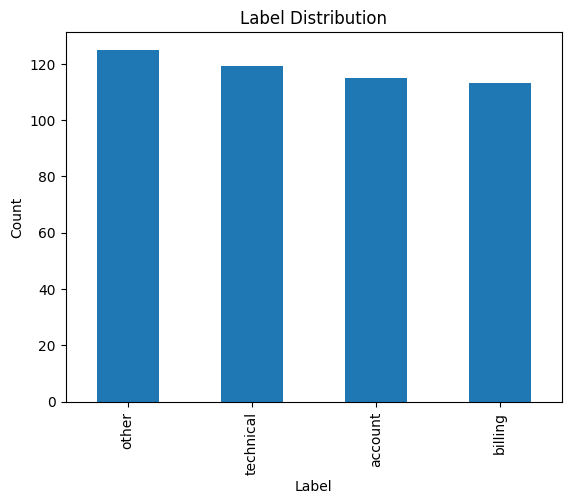

In [32]:
import matplotlib.pyplot as plt
import seaborn as sns
print(df['label'].value_counts())

# Plotting bar chart to know the distirbution of each class in the label class
df['label'].value_counts().plot(kind = 'bar', )
plt.title('Label Distribution')
plt.xlabel('Label')
plt.ylabel('Count')
plt.show()

# Next is Text Analysis

In [33]:
#Calculate text lengths (in words)
# Convert each text to string and split into words, then count them
text_length = df["text"].astype(str).apply(lambda x: len(x.split()))

# Print summary statistics
print("Text length (in words): Summary statistics:")
print(text_length.describe())


Text length (in words): Summary statistics:
count    472.000000
mean       7.381356
std        1.081946
min        5.000000
25%        7.000000
50%        7.000000
75%        8.000000
max       10.000000
Name: text, dtype: float64


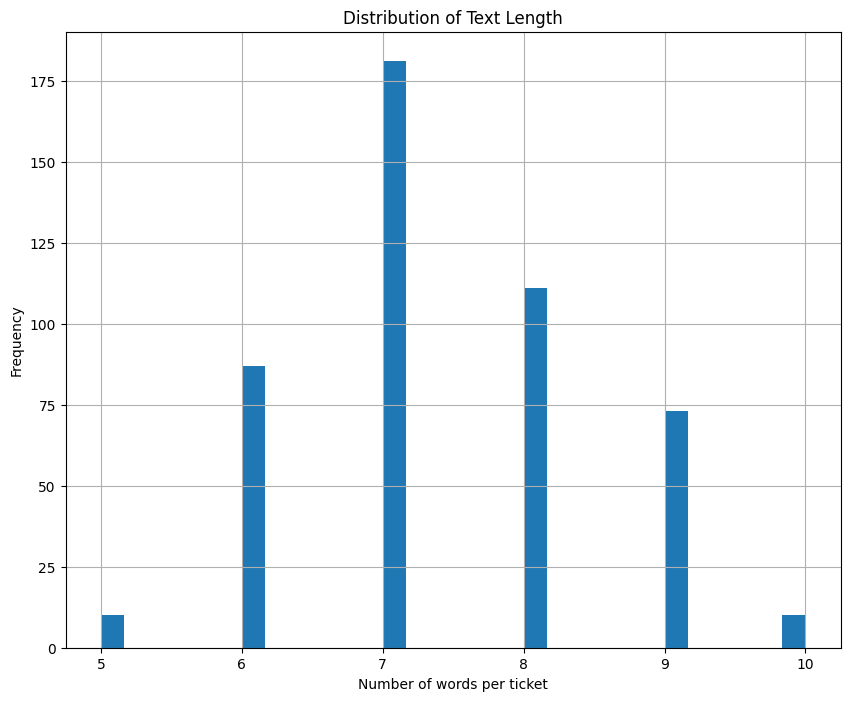

In [34]:
#plotting Test Statistics
plt.figure(figsize=(10,8))
text_length.hist(bins=30)
plt.title('Distribution of Text Length')
plt.xlabel('Number of words per ticket')
plt.ylabel('Frequency')
plt.show()

In [35]:
# dropping two added columns
df.drop(['has_weird_symbol', 'symbol_context'], axis=1, inplace = True)

In [36]:
df.head()

,text,label,ticket_id,agent_name
0,Where can I find API rate limits documentation?,other,1000,Dana
1,Can I migrate data from Freshdesk?,other,1001,Bob
2,Cannot update billing address; page keeps relo...,billing,1002,Charlie
3,Looking for a product roadmap or upcoming feat...,other,1003,Dana
4,Dark mode toggled but UI stays light.,technical,1004,Alice


In [37]:
if set(["text","label"]).issubset(df.columns):
    def sample_per_class(dataframe, col_label="label", n=3):
        samples = []
        for cls, group in dataframe.groupby(col_label):
            s = group.sample(min(n, len(group)), random_state=RANDOM_SEED)[["text", col_label]]
            s.insert(0, "sample_of", cls)
            samples.append(s)
        return pd.concat(samples, ignore_index=True)

    samples_df = sample_per_class(df, "label", n=3)
    display(samples_df)
else:
    print("Skipping samples per class — missing 'text' or 'label'.")

,sample_of,text,label
0,account,Profile picture upload fails with unknown error.,account
1,account,How do I delete my account and all data?,account
2,account,Profile picture upload fails with unknown error.,account
3,billing,Subscription renewal charged incorrectly this ...,billing
4,billing,Promo code SAVE20 not applied at checkout.,billing
5,billing,Currency converted incorrectly; expected GBP.,billing
6,other,Do you offer discounts for students or NGOs?,other
7,other,Please provide onboarding training for my team.,other
8,other,Requesting invoice to be sent monthly instead ...,other
9,technical,File export to CSV generates corrupted file.,technical


# Baseline models for ticket classification

This notebook trains simple baseline models for the customer support ticket classification task. The goals are:

1. Establish a very simple majority-class baseline.
2. Train a TF-IDF + Logistic Regression baseline.
3. Produce clear evaluation metrics and confusion matrices.



## Data loading and train/test split

Load the cleaned tickets dataset and split into features (text) and labels. We use stratified sampling to preserve class distribution between train and test sets and set a random seed for reproducibility.

In [38]:
# Standard imports used throughout the notebook
import pandas as pd
import numpy as np
import json
from sklearn.model_selection import train_test_split, cross_val_score, learning_curve
from sklearn.dummy import DummyClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report
from sklearn.pipeline import Pipeline
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

# Set style for better visualizations
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

# Load cleaned dataset (relative path)
df = pd.read_csv('/content/Thrive_Internship_ML_A/data/clean/clean_tickets.csv')
print(f'Shape of dataframe: {df.shape}')
df.head()

Shape of dataframe: (472, 4)


,text,label,ticket_id,agent_name
0,Where can I find API rate limits documentation?,other,1000,Dana
1,Can I migrate data from Freshdesk?,other,1001,Bob
2,Cannot update billing address; page keeps relo...,billing,1002,Charlie
3,Looking for a product roadmap or upcoming feat...,other,1003,Dana
4,Dark mode toggled but UI stays light.,technical,1004,Alice


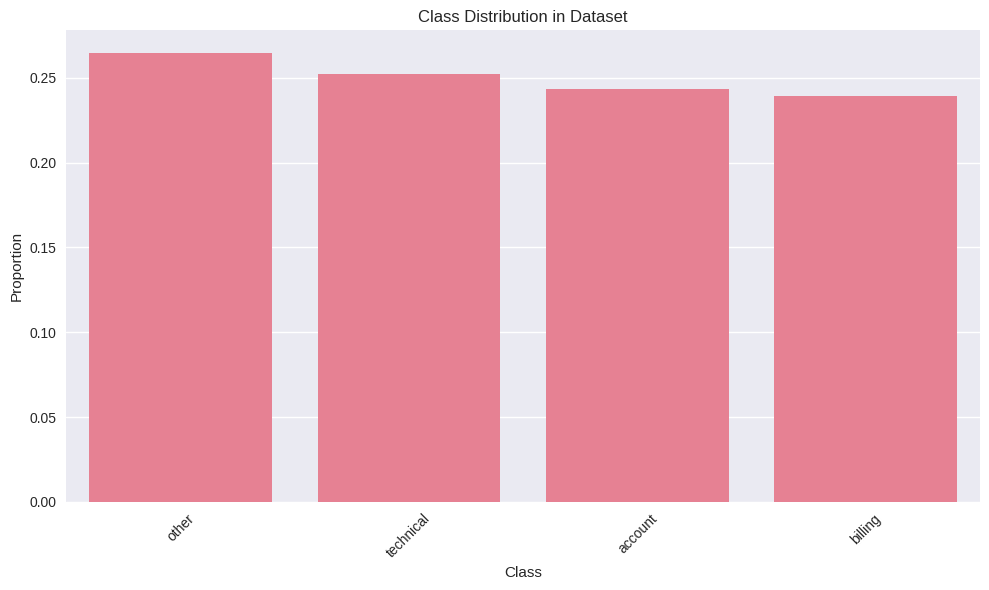

In [39]:
# Visualize class distribution
plt.figure(figsize=(10, 6))
class_dist = df['label'].value_counts(normalize=True)
sns.barplot(x=class_dist.index, y=class_dist.values)
plt.title('Class Distribution in Dataset')
plt.xlabel('Class')
plt.ylabel('Proportion')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [40]:
print('\nLabel distribution:')
for label, prop in class_dist.items():
    print(f'{label}: {prop:.3f}')

# Split into features and labels
X = df['text']
y = df['label']

# First split: separate test set
X_temp, X_test, y_temp, y_test = train_test_split(
    X, y,
    test_size=0.2,
    stratify=y,
    random_state=42
)

# Second split: create validation set from remaining data
X_train, X_val, y_train, y_val = train_test_split(
    X_temp, y_temp,
    test_size=0.25,  # 0.25 x 0.8 = 0.2 of original data
    stratify=y_temp,
    random_state=42
)

print('\nData split sizes:')
print(f'Training set: {len(X_train)} samples')
print(f'Validation set: {len(X_val)} samples')
print(f'Test set: {len(X_test)} samples')


Label distribution:
other: 0.265
technical: 0.252
account: 0.244
billing: 0.239

Data split sizes:
Training set: 282 samples
Validation set: 95 samples
Test set: 95 samples


## Majority-class baseline

We use scikit-learn's DummyClassifier with the 'most_frequent' strategy. This baseline always predicts the most common class from the training set and is useful to show the minimum performance to beat.

Baseline 5-fold CV scores: [0.10964912 0.10964912 0.11317907 0.11317907 0.11317907]
Average CV F1: 0.1118 (+/- 0.0035)

Majority baseline metrics (validation set):
  Accuracy: 0.2632
  Weighted F1: 0.1096

Classification report (majority baseline):
              precision    recall  f1-score   support

     account       0.00      0.00      0.00        23
     billing       0.00      0.00      0.00        23
       other       0.26      1.00      0.42        25
   technical       0.00      0.00      0.00        24

    accuracy                           0.26        95
   macro avg       0.07      0.25      0.10        95
weighted avg       0.07      0.26      0.11        95



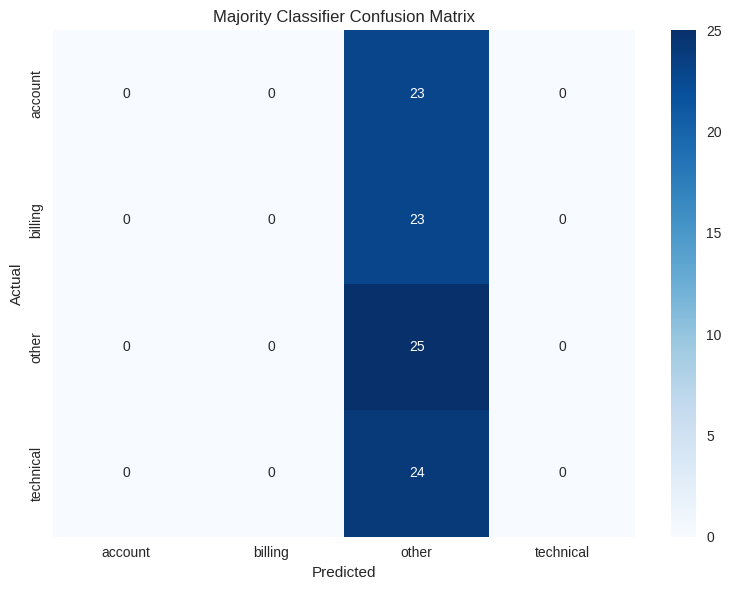

In [41]:
# Create pipeline for baseline model
baseline_pipe = Pipeline([
    ('vectorizer', TfidfVectorizer()),  # Default vectorizer for baseline
    ('classifier', DummyClassifier(strategy='most_frequent')),
])

# Fit and evaluate baseline
baseline_pipe.fit(X_train, y_train)

# Cross-validation scores for baseline
baseline_cv_scores = cross_val_score(
    baseline_pipe, X_train, y_train,
    cv=5, scoring='f1_weighted'
)

print("Baseline 5-fold CV scores:", baseline_cv_scores)
print(f"Average CV F1: {baseline_cv_scores.mean():.4f} (+/- {baseline_cv_scores.std() * 2:.4f})")

# Predict on validation set
y_pred_majority = baseline_pipe.predict(X_val)

# Compute evaluation metrics
acc_majority = accuracy_score(y_val, y_pred_majority)
f1_majority = f1_score(y_val, y_pred_majority, average='weighted')
cm_majority = confusion_matrix(y_val, y_pred_majority)

print('\nMajority baseline metrics (validation set):')
print(f'  Accuracy: {acc_majority:.4f}')
print(f'  Weighted F1: {f1_majority:.4f}')
print('\nClassification report (majority baseline):')
print(classification_report(y_val, y_pred_majority, zero_division=0))

# Save confusion matrix figure to artifacts for MLflow
import os
os.makedirs('../artifacts', exist_ok=True)
plt.figure(figsize=(8,6))
sns.heatmap(cm_majority, annot=True, fmt='d', cmap='Blues',
            xticklabels=sorted(y.unique()), yticklabels=sorted(y.unique()))
plt.title('Majority Classifier Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.tight_layout()
majority_cm_path = '../artifacts/cm_majority.png'
plt.savefig(majority_cm_path)
plt.show()

Computing learning curves for Majority Classifier (this may take a moment)...


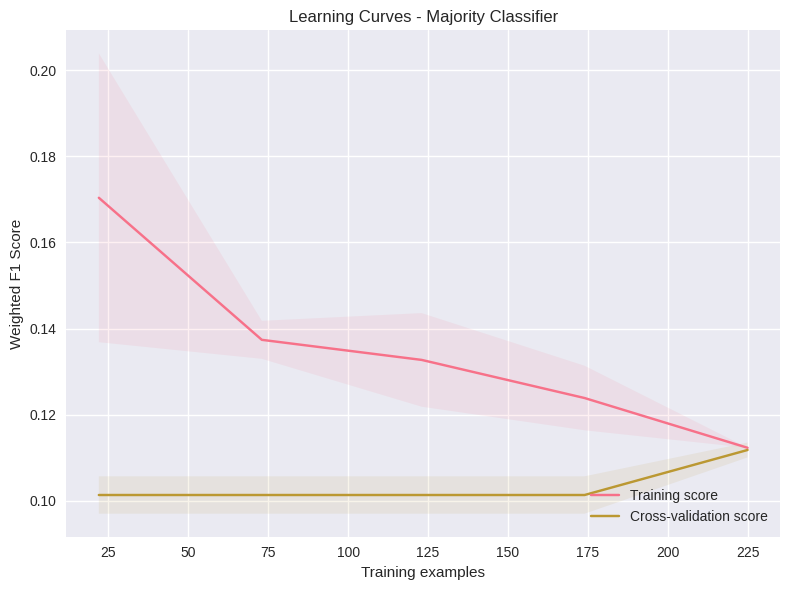

Saved majority learning curve to: ../artifacts/lc_majority.png


In [42]:
# Learning curve for Majority Classifier
from sklearn.model_selection import learning_curve
import numpy as np
import matplotlib.pyplot as plt
import os

print("Computing learning curves for Majority Classifier (this may take a moment)...")
train_sizes, train_scores, val_scores = learning_curve(
    baseline_pipe, X_train, y_train,
    train_sizes=np.linspace(0.1, 1.0, 5),
    cv=5,
    scoring='f1_weighted',
    n_jobs=-1
)

train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
val_mean = np.mean(val_scores, axis=1)
val_std = np.std(val_scores, axis=1)

plt.figure(figsize=(8, 6))
plt.plot(train_sizes, train_mean, label='Training score')
plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, alpha=0.1)
plt.plot(train_sizes, val_mean, label='Cross-validation score')
plt.fill_between(train_sizes, val_mean - val_std, val_mean + val_std, alpha=0.1)

plt.xlabel('Training examples')
plt.ylabel('Weighted F1 Score')
plt.title('Learning Curves - Majority Classifier')
plt.legend(loc='lower right')
plt.grid(True)

# Save figure to artifacts
os.makedirs('../artifacts', exist_ok=True)
lc_path = '../artifacts/lc_majority.png'
plt.tight_layout()
plt.savefig(lc_path)
plt.show()
print(f"Saved majority learning curve to: {lc_path}")

In [43]:
# Create groups based on text similarity to ensure CV splits respect text clusters
from sklearn.feature_extraction.text import HashingVectorizer
from sklearn.cluster import MiniBatchKMeans
from scipy.sparse import hstack
from sklearn.model_selection import StratifiedGroupKFold

def create_text_groups(texts, n_char_features=100, n_word_features=100, random_state=42):
    """Create groups from text similarity using character and word n-grams."""
    # Preprocess
    processed_texts = texts.apply(lambda x: str(x).lower())

    # Create char and word n-gram features
    char_vec = HashingVectorizer(
        n_features=n_char_features,
        analyzer='char',
        ngram_range=(3, 5)
    )
    word_vec = HashingVectorizer(
        n_features=n_word_features,
        analyzer='word',
        ngram_range=(1, 2)
    )

    # Transform texts
    X_char = char_vec.transform(processed_texts)
    X_word = word_vec.transform(processed_texts)
    X_combined = hstack([X_char, X_word])

    # Cluster texts
    n_clusters = min(50, len(texts) // 10)  # Cap at 50 groups
    kmeans = MiniBatchKMeans(
        n_clusters=n_clusters,
        random_state=random_state
    )
    groups = kmeans.fit_predict(X_combined)
    return groups

# Create groups for CV
print("Creating text similarity groups for cross-validation...")
groups = create_text_groups(X_train)
print(f"Created {len(np.unique(groups))} groups from {len(X_train)} texts.")

# Initialize group-aware CV splitter
group_kfold = StratifiedGroupKFold(n_splits=5, shuffle=True, random_state=42)

# Quick verification
n_unique_groups = len(np.unique(groups))
print(f"\nGroup statistics:")
print(f"Number of texts: {len(X_train)}")
print(f"Number of unique groups: {n_unique_groups}")
print(f"Average group size: {len(X_train) / n_unique_groups:.1f}")

Creating text similarity groups for cross-validation...
Created 28 groups from 282 texts.

Group statistics:
Number of texts: 282
Number of unique groups: 28
Average group size: 10.1


## Create Text Similarity Groups for Cross-Validation

Before we start modeling, we'll create groups based on text similarity. This ensures our cross-validation splits don't put similar texts in different folds, which would lead to overly optimistic scores.

Process:
1. Apply HashingVectorizer to create character and word n-gram features
2. Combine these features and cluster similar texts using MiniBatchKMeans
3. The resulting cluster assignments become our groups for StratifiedGroupKFold

These groups will be used consistently throughout all cross-validation operations in the notebook.

## TF-IDF vectorization

Convert raw text into numerical features using TF-IDF. We limit to the top 5,000 features for speed and to reduce noise. The vectorizer is fit on the training data only to avoid data leakage.

In [44]:
# Create pipeline for TF-IDF + LogReg
model_pipe = Pipeline([
    ('vectorizer', TfidfVectorizer(
        max_features=5000,
        ngram_range=(1, 2),
        stop_words='english',
        min_df=2,
        max_df=0.95
    )),
    ('classifier', LogisticRegression(random_state=42, max_iter=1000))
])

# Define parameter grid
param_grid = {
    'classifier__C': [0.1, 1.0, 10.0],
    'classifier__class_weight': [None, 'balanced'],
    'vectorizer__max_features': [3000, 5000],
    'vectorizer__ngram_range': [(1, 1), (1, 2)]
}

# Perform cross-validated grid search on training data
from sklearn.model_selection import GridSearchCV
grid_search = GridSearchCV(
    model_pipe,
    param_grid,
    cv=5,
    scoring='f1_weighted',
    n_jobs=-1,
    verbose=1
)

# Fit on training data
grid_search.fit(X_train, y_train)

print(f'\nBest parameters found: {grid_search.best_params_}')
print(f'Best cross-validation score: {grid_search.best_score_:.4f}')

Fitting 5 folds for each of 24 candidates, totalling 120 fits

Best parameters found: {'classifier__C': 0.1, 'classifier__class_weight': None, 'vectorizer__max_features': 3000, 'vectorizer__ngram_range': (1, 2)}
Best cross-validation score: 0.9929


In [45]:
# Verify data split integrity
print("Checking for data leakage...")
print("\nSample overlap between splits:")
print(f"Train-Val overlap: {len(set(X_train.index) & set(X_val.index))}")
print(f"Train-Test overlap: {len(set(X_train.index) & set(X_test.index))}")
print(f"Val-Test overlap: {len(set(X_val.index) & set(X_test.index))}")

# Check feature independence
print("\nVerifying TF-IDF computation independence:")
# Create two separate vectorizers with same parameters
vec1 = TfidfVectorizer(max_features=5000)
vec2 = TfidfVectorizer(max_features=5000)

# Fit and transform on train vs test
X_train_vec1 = vec1.fit_transform(X_train)
X_test_vec2 = vec2.fit_transform(X_test)

# Compare vocabulary sizes
print(f"Train vocab size: {len(vec1.vocabulary_)}")
print(f"Test vocab size: {len(vec2.vocabulary_)}")
print(f"Vocabulary overlap: {len(set(vec1.vocabulary_.keys()) & set(vec2.vocabulary_.keys()))}")

# Print unique label counts in each split
print("\nLabel distribution in splits:")
print("\nTrain set:")
print(y_train.value_counts(normalize=True))
print("\nValidation set:")
print(y_val.value_counts(normalize=True))
print("\nTest set:")
print(y_test.value_counts(normalize=True))

Checking for data leakage...

Sample overlap between splits:
Train-Val overlap: 0
Train-Test overlap: 0
Val-Test overlap: 0

Verifying TF-IDF computation independence:
Train vocab size: 233
Test vocab size: 213
Vocabulary overlap: 209

Label distribution in splits:

Train set:
label
other        0.265957
technical    0.251773
account      0.244681
billing      0.237589
Name: proportion, dtype: float64

Validation set:
label
other        0.263158
technical    0.252632
billing      0.242105
account      0.242105
Name: proportion, dtype: float64

Test set:
label
other        0.263158
technical    0.252632
account      0.242105
billing      0.242105
Name: proportion, dtype: float64


In [46]:
# Enhanced TF-IDF + LogReg pipeline with feature selection and scaling
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.preprocessing import MaxAbsScaler  # Safe for sparse matrices

# Create pipeline with feature selection and appropriate scaler
model_pipe = Pipeline([
    ('vectorizer', TfidfVectorizer(
        ngram_range=(1, 2),
        stop_words='english',
        min_df=1,  # Start conservative, let grid search explore
        max_df=0.95
    )),
    ('scaler', MaxAbsScaler()),  # Scale features for chi2 and L1
    ('feature_select', SelectKBest(chi2)),
    ('classifier', LogisticRegression(
        random_state=42,
        max_iter=2000,  # Increase for L1
        solver='saga'  # Supports both L1 and L2
    ))
])

# Enhanced parameter grid with:
# 1. Stronger regularization (smaller C values)
# 2. L1 and L2 penalties
# 3. Feature selection and dimensionality reduction
# 4. Class balancing
param_grid = {
    'vectorizer__max_features': [100, 200, 300],  # Reduced dimensionality
    'feature_select__k': [20, 50, 100],  # Further reduce features
    'classifier__C': [0.01, 0.05, 0.1, 0.5],  # Stronger regularization
    'classifier__penalty': ['l1', 'l2'],  # Try both L1 (sparse) and L2
    'classifier__class_weight': ['balanced']  # Handle class imbalance
}

# Defensive CV sizing: ensure number of folds does not exceed smallest class count
min_class_count = int(y_train.value_counts().min())
cv_splits = min(5, min_class_count) if min_class_count >= 2 else 2
if cv_splits < 2:
    print(f"Warning: very small class sizes; setting cv_splits=2 (min class count={min_class_count})")

# Initialize group-aware CV with stratification
from sklearn.model_selection import GroupKFold, StratifiedGroupKFold
group_kfold = StratifiedGroupKFold(n_splits=cv_splits, shuffle=True, random_state=42)

# Grid search with group-aware CV
from sklearn.model_selection import GridSearchCV
grid_search = GridSearchCV(
    model_pipe,
    param_grid,
    cv=group_kfold.split(X_train, y_train, groups=groups),
    scoring='f1_weighted',
    n_jobs=-1,
    verbose=2,
    refit=True
)

# Add frequency feature to training data
X_train_with_freq = pd.DataFrame({'text': X_train})
text_frequencies = X_train.value_counts()
X_train_with_freq['text_frequency'] = X_train_with_freq['text'].map(text_frequencies)

print("Starting grid search with group-aware CV...")
grid_search.fit(X_train, y_train)

print(f"\nBest parameters found: {grid_search.best_params_}")
print(f"Best cross-validation score: {grid_search.best_score_:.4f}")

# Analyze feature importance of best model
best_model = grid_search.best_estimator_
vectorizer = best_model.named_steps['vectorizer']
feature_selector = best_model.named_steps['feature_select']
classifier = best_model.named_steps['classifier']

if hasattr(vectorizer, 'get_feature_names_out'):
    feature_names = vectorizer.get_feature_names_out()
    selected_features_mask = feature_selector.get_support()
    selected_features = feature_names[selected_features_mask]

    if hasattr(classifier, 'coef_'):
        feature_importance = pd.DataFrame({
            'feature': selected_features,
            'importance': np.abs(classifier.coef_[0])
        }).sort_values('importance', ascending=False)

        print("\nTop 10 most important features:")
        print(feature_importance.head(10))

Starting grid search with group-aware CV...
Fitting 5 folds for each of 72 candidates, totalling 360 fits

Best parameters found: {'classifier__C': 0.05, 'classifier__class_weight': 'balanced', 'classifier__penalty': 'l2', 'feature_select__k': 100, 'vectorizer__max_features': 100}
Best cross-validation score: 0.2909

Top 10 most important features:
         feature  importance
2        account    0.310608
52          need    0.285118
30        factor    0.186810
16     code sent    0.186475
67  phone number    0.186475
56   number code    0.186475
98        verify    0.186475
99  verify phone    0.186475
66         phone    0.186475
31         fails    0.179302


## TF-IDF + Logistic Regression baseline

Train a regularized Logistic Regression on TF-IDF features. We increase max_iter to ensure convergence on larger feature spaces. We report accuracy, weighted F1, and show a classification report for per-class metrics.\

Generating learning curves (this may take a moment)...


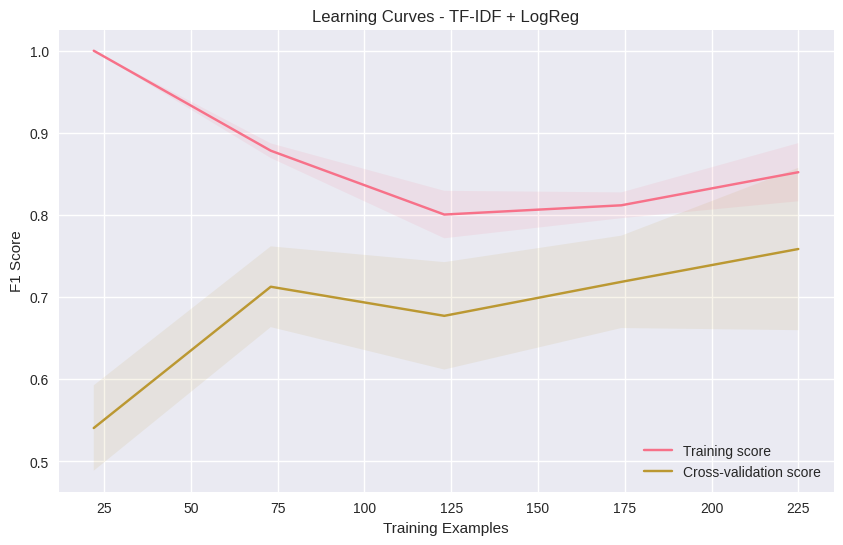


Validation Set Performance:
              precision    recall  f1-score   support

     account       0.83      0.83      0.83        23
     billing       0.85      0.74      0.79        23
       other       0.56      1.00      0.71        25
   technical       1.00      0.29      0.45        24

    accuracy                           0.72        95
   macro avg       0.81      0.71      0.70        95
weighted avg       0.80      0.72      0.69        95


Test Set Performance:
              precision    recall  f1-score   support

     account       0.74      0.87      0.80        23
     billing       0.86      0.78      0.82        23
       other       0.69      1.00      0.82        25
   technical       1.00      0.46      0.63        24

    accuracy                           0.78        95
   macro avg       0.82      0.78      0.77        95
weighted avg       0.82      0.78      0.77        95



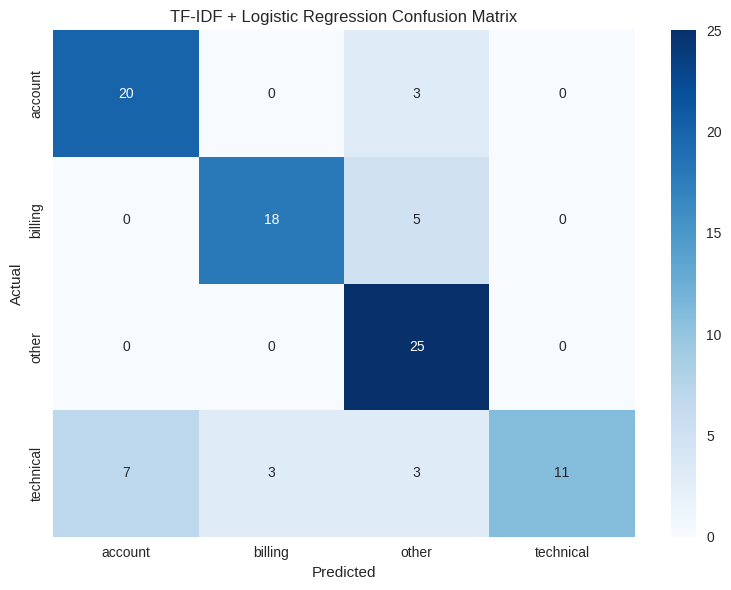


Model Performance Comparison:


,Metric,Validation,Test
0,Accuracy,0.7158,0.7789
1,Weighted F1,0.6935,0.7663


In [47]:
# Get best model
best_model = grid_search.best_estimator_

# Plot learning curves to check for overfitting
def plot_learning_curves(estimator, title):
    train_sizes, train_scores, val_scores = learning_curve(
        estimator, X_train, y_train,
        train_sizes=np.linspace(0.1, 1.0, 5),
        cv=5, scoring='f1_weighted', n_jobs=-1
    )

    train_mean = np.mean(train_scores, axis=1)
    train_std = np.std(train_scores, axis=1)
    val_mean = np.mean(val_scores, axis=1)
    val_std = np.std(val_scores, axis=1)

    plt.figure(figsize=(10, 6))
    plt.plot(train_sizes, train_mean, label='Training score')
    plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, alpha=0.1)
    plt.plot(train_sizes, val_mean, label='Cross-validation score')
    plt.fill_between(train_sizes, val_mean - val_std, val_mean + val_std, alpha=0.1)

    plt.xlabel('Training Examples')
    plt.ylabel('F1 Score')
    plt.title(f'Learning Curves - {title}')
    plt.legend(loc='lower right')
    plt.grid(True)
    plt.show()

print("Generating learning curves (this may take a moment)...")
plot_learning_curves(best_model, 'TF-IDF + LogReg')

# Evaluate on validation set
y_pred_val = best_model.predict(X_val)
print('\nValidation Set Performance:')
print(classification_report(y_val, y_pred_val))

# Final evaluation on test set
y_pred_test = best_model.predict(X_test)
print('\nTest Set Performance:')
print(classification_report(y_test, y_pred_test))

# Store metrics for final comparison
acc_logreg = accuracy_score(y_test, y_pred_test)
f1_logreg = f1_score(y_test, y_pred_test, average='weighted')
cm_logreg = confusion_matrix(y_test, y_pred_test)

# Save confusion matrix for logreg
import os
os.makedirs('../artifacts', exist_ok=True)
plt.figure(figsize=(8,6))
sns.heatmap(cm_logreg, annot=True, fmt='d', cmap='Blues',
            xticklabels=sorted(y.unique()), yticklabels=sorted(y.unique()))
plt.title('TF-IDF + Logistic Regression Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.tight_layout()
logreg_cm_path = '../artifacts/cm_logreg.png'
plt.savefig(logreg_cm_path)
plt.show()

# Compare validation and test performance
print('\nModel Performance Comparison:')
metrics_df = pd.DataFrame({
    'Metric': ['Accuracy', 'Weighted F1'],
    'Validation': [
        accuracy_score(y_val, y_pred_val),
        f1_score(y_val, y_pred_val, average='weighted')
    ],
    'Test': [
        accuracy_score(y_test, y_pred_test),
        f1_score(y_test, y_pred_test, average='weighted')
    ]
})
display(metrics_df.round(4))

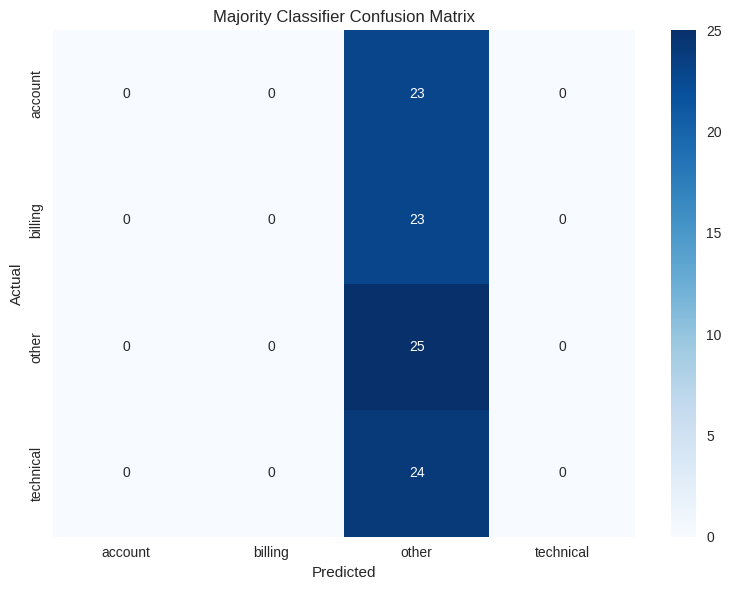

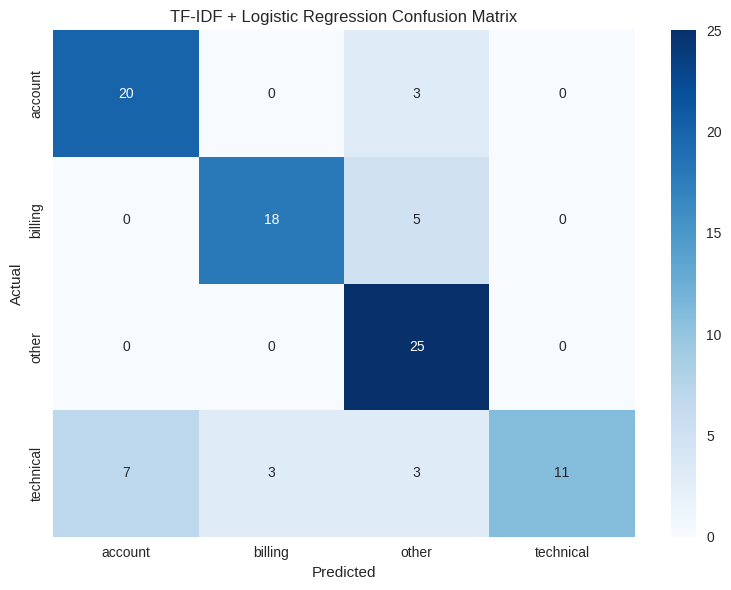


Summary of baseline results:


,model,accuracy,weighted_f1
0,majority,0.263158,0.109649
1,tfidf_logreg,0.778947,0.766271


In [48]:
def plot_confusion(cm, classes, title, figsize=(8,6)):
    """Plot a confusion matrix with class labels.
    Args:
        cm: confusion matrix (2D array)
        classes: list of class labels in the order used by the matrix
        title: plot title
    """
    plt.figure(figsize=figsize)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=classes, yticklabels=classes)
    plt.title(title)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.tight_layout()
    plt.show()

# Determine class order from the training labels to keep axes consistent
classes = sorted(y.unique())
plot_confusion(cm_majority, classes, 'Majority Classifier Confusion Matrix')
plot_confusion(cm_logreg, classes, 'TF-IDF + Logistic Regression Confusion Matrix')

# Save plots if not already saved
import os
os.makedirs('../artifacts', exist_ok=True)
if not os.path.exists('../artifacts/cm_majority.png'):
    plt.figure(figsize=(8,6))
    sns.heatmap(cm_majority, annot=True, fmt='d', cmap='Blues',
                xticklabels=classes, yticklabels=classes)
    plt.title('Majority Classifier Confusion Matrix')
    plt.tight_layout()
    plt.savefig('../artifacts/cm_majority.png')
    plt.close()

if not os.path.exists('../artifacts/cm_logreg.png'):
    plt.figure(figsize=(8,6))
    sns.heatmap(cm_logreg, annot=True, fmt='d', cmap='Blues',
                xticklabels=classes, yticklabels=classes)
    plt.title('TF-IDF + Logistic Regression Confusion Matrix')
    plt.tight_layout()
    plt.savefig('../artifacts/cm_logreg.png')
    plt.close()

# Summary table comparing baselines
results = pd.DataFrame({
    'model': ['majority', 'tfidf_logreg'],
    'accuracy': [acc_majority, acc_logreg],
    'weighted_f1': [f1_majority, f1_logreg]
})
print('\nSummary of baseline results:')
display(results)

MLflow integration

In [49]:
import mlflow
import os

# Set tracking URI to use shared mlruns folder
mlflow.set_tracking_uri("file:../mlruns")
# Use separate experiment for baseline models
mlflow.set_experiment("baseline_models")

def safe_start_run(run_name, nested=False):
    if mlflow.active_run() is not None:
        mlflow.end_run()
    return mlflow.start_run(run_name=run_name, nested=nested)

# Start a parent run safely
with safe_start_run("Baseline Model Experiments") as parent_run:

    # Majority Classifier (nested run)
    with safe_start_run("Majority Classifier", nested=True):
        mlflow.set_tag("component", "baseline")
        mlflow.set_tag("model_family", "majority_classifier")
        mlflow.log_param("model_type", "DummyClassifier")
        mlflow.log_param("strategy", "most_frequent")
        mlflow.log_metric("accuracy", acc_majority)
        mlflow.log_metric("weighted_f1", f1_majority)
        if os.path.exists(majority_cm_path):
            mlflow.log_artifact(majority_cm_path, artifact_path="evaluation")
        else:
            print(f"Warning: artifact not found: {majority_cm_path}")

    # TF-IDF + Logistic Regression (nested run)
    with safe_start_run("TFIDF + Logistic Regression", nested=True):
        mlflow.set_tag("component", "baseline")
        mlflow.set_tag("model_family", "tfidf_logreg")
        mlflow.log_param("model_type", "LogisticRegression")
        mlflow.log_param("vectorizer", "TF-IDF")
        mlflow.log_param("max_features", 5000)
        mlflow.log_param("solver", "saga")
        mlflow.log_param("penalty", "l2")
        mlflow.log_metric("accuracy", acc_logreg)
        mlflow.log_metric("weighted_f1", f1_logreg)
        if os.path.exists(logreg_cm_path):
            mlflow.log_artifact(logreg_cm_path, artifact_path="evaluation")
        else:
            print(f"Warning: artifact not found: {logreg_cm_path}")


/usr/local/lib/python3.12/dist-packages/mlflow/tracking/_tracking_service/utils.py:177: FutureWarning: The filesystem tracking backend (e.g., './mlruns') will be deprecated in February 2026. Consider transitioning to a database backend (e.g., 'sqlite:///mlflow.db') to take advantage of the latest MLflow features. See https://github.com/mlflow/mlflow/issues/18534 for more details and migration guidance.
  return FileStore(store_uri, store_uri)
2025/12/05 11:26:05 INFO mlflow.tracking.fluent: Experiment with name 'baseline_models' does not exist. Creating a new experiment.


In [50]:
import json

# Ensure artifacts directory exists
import os
os.makedirs('../artifacts', exist_ok=True)

metrics = {
    "majority_classifier": {
        "accuracy": float(acc_majority),
        "weighted_f1": float(f1_majority)
    },
    "tfidf_logistic_regression": {
        "accuracy": float(acc_logreg),
        "weighted_f1": float(f1_logreg)
    }
}

metrics_path = '../artifacts/baseline_metrics.json'
with open(metrics_path, "w") as f:
    json.dump(metrics, f, indent=4)

# Log metrics artifact to MLflow if available
if os.path.exists(metrics_path):
    mlflow.log_artifact(metrics_path, artifact_path="artifacts")
    print(f"Logged metrics to MLflow: {metrics_path}")
else:
    print(f"Warning: could not find metrics file to log: {metrics_path}")


Logged metrics to MLflow: ../artifacts/baseline_metrics.json


In [51]:
# Save the trained baseline model and metadata for comparison/deployment
import os
import json
import joblib

# Save model in artifacts directory
model_dir = "../artifacts/models/baseline"
os.makedirs(model_dir, exist_ok=True)

# Prefer `best_model` (GridSearch best estimator) then fall back to common pipeline names
model_to_save = None
for name in ("best_model", "baseline_pipe", "model_pipe", "baseline_cv_scores"):
    if name in globals():
        candidate = globals()[name]
        # only save sklearn Pipeline or estimator objects
        try:
            # quick duck-typing check
            if hasattr(candidate, "predict") or hasattr(candidate, "transform"):
                model_to_save = candidate
                break
        except Exception:
            pass

if model_to_save is None:
    raise NameError("No trained model pipeline found to save. Expected `best_model`, `baseline_pipe`, or `model_pipe`.")

pipe_path = os.path.join(model_dir, "baseline_pipeline.joblib")
joblib.dump(model_to_save, pipe_path)
print(f"Saved pipeline to: {pipe_path}")

# Save metadata (classes and metrics if available)
meta = {}
if "classes" in globals():
    meta["classes"] = list(classes)
if "metrics" in globals():
    # metrics may already be serializable, otherwise cast to str
    try:
        json.dumps(metrics)
        meta["metrics"] = metrics
    except Exception:
        meta["metrics"] = {k: str(v) for k, v in metrics.items()} if isinstance(metrics, dict) else str(metrics)

meta_path = os.path.join(model_dir, "metadata.json")
with open(meta_path, "w", encoding="utf-8") as f:
    json.dump(meta, f, indent=2, ensure_ascii=False)
print(f"Saved metadata to: {meta_path}")

# Log model and metadata to MLflow
try:
    # Log raw artifacts for reproducibility
    mlflow.log_artifact(pipe_path, artifact_path="models/baseline")
    mlflow.log_artifact(meta_path, artifact_path="models/baseline")
    print("Logged baseline model and metadata to MLflow (artifacts)")

    # Also log as an MLflow Model (sklearn) so it can be registered and served
    try:
        import mlflow.sklearn
        run_id = mlflow.active_run().info.run_id if mlflow.active_run() else None
        mlflow.sklearn.log_model(model_to_save, artifact_path="model")
        if run_id is None:
            run_id = mlflow.active_run().info.run_id
        model_uri = f"runs:/{run_id}/model"
        try:
            reg = mlflow.register_model(model_uri, "ticket-classifier-baseline")
            print(f"Registered baseline model to Model Registry: {reg.name} (version {reg.version})")
        except Exception as reg_e:
            print(f"Model registration skipped/failed: {reg_e}")
    except Exception as skl_e:
        print(f"sklearn model logging skipped: {skl_e}")

except Exception as e:
    print(f"Note: MLflow artifact logging skipped or failed: {e}")

# Quick verification: attempt to load
loaded = joblib.load(pipe_path)
print("Loaded saved pipeline. Example predict (on small sample) if X_test available:")
if "X_test" in globals():
    try:
        sample_X = X_test.iloc[:5] if hasattr(X_test, "iloc") else X_test[:5]
        preds = loaded.predict(sample_X)
        print("Prediction sample:", preds)
    except Exception as e:
        print("Could not run sample prediction:", e)
else:
    print("No X_test found in notebook globals to run a sample prediction.")


2025/12/05 11:26:05 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


Saved pipeline to: ../artifacts/models/baseline/baseline_pipeline.joblib
Saved metadata to: ../artifacts/models/baseline/metadata.json
Logged baseline model and metadata to MLflow (artifacts)


/usr/local/lib/python3.12/dist-packages/mlflow/tracking/_model_registry/utils.py:215: FutureWarning: The filesystem model registry backend (e.g., './mlruns') will be deprecated in February 2026. Consider transitioning to a database backend (e.g., 'sqlite:///mlflow.db') to take advantage of the latest MLflow features. See https://github.com/mlflow/mlflow/issues/18534 for more details and migration guidance.
  return FileStore(store_uri)
Successfully registered model 'ticket-classifier-baseline'.
2025/12/05 11:26:16 WARNING mlflow.tracking._model_registry.fluent: Run with id 8485fac8da934cdf837097e2eb56a936 has no artifacts at artifact path 'model', registering model based on models:/m-02f263b396bd43b59829594fffbf0f5b instead


Registered baseline model to Model Registry: ticket-classifier-baseline (version 1)
Loaded saved pipeline. Example predict (on small sample) if X_test available:
Prediction sample: ['account' 'technical' 'other' 'other' 'other']


Created version '1' of model 'ticket-classifier-baseline'.


# Fine-tuning DistilBERT for Ticket Classification

This notebook demonstrates how to fine-tune a DistilBERT model for classifying customer support tickets into different categories using a group-aware cross-validation strategy, class-weighted loss, and early stopping. It also includes MLflow tracking for experiment management and model logging for deployment.

In [52]:
%pip install transformers torch scikit-learn mlflow matplotlib

## 1. Setup and Imports

This section imports all the necessary libraries and modules for data processing, model building, training, and evaluation, including `transformers`, `torch`, `scikit-learn`, `mlflow`, and `matplotlib`.

In [53]:
import os
import json
import numpy as np
import pandas as pd
import torch
import mlflow
import matplotlib.pyplot as plt

from sklearn.model_selection import StratifiedGroupKFold
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score
from torch.utils.data import Dataset, DataLoader
from transformers import (
    DistilBertTokenizerFast,
    DistilBertForSequenceClassification,
    get_linear_schedule_with_warmup,
)
from torch.optim import AdamW # Corrected import location
from tqdm.auto import tqdm

In [54]:
df = pd.read_csv("/content/Thrive_Internship_ML_A/data/clean/clean_tickets.csv")  # replace with your dataset path

labels = sorted(df["label"].unique())
label2id = {l: i for i, l in enumerate(labels)}
id2label = {i: l for l, i in label2id.items()}
df["label_id"] = df["label"].map(label2id)

# Add the 'group' column by grouping by 'text'
df['group'] = df.groupby('text').ngroup()

# Example: assume we have a 'group' column
groups = df["group"].values  # replace with your actual group column

## 3. Data Splitting with StratifiedGroupKFold

This section implements the data splitting strategy using `StratifiedGroupKFold`. This ensures that samples with the same text (duplicates) are kept within the same split (train, validation, or test) and that the distribution of labels is maintained across these splits, which is crucial for preventing data leakage and obtaining a reliable evaluation.

In [55]:
# StratifiedGroupKFold ensures stratification by label and isolation by group
sgkf = StratifiedGroupKFold(n_splits=10, shuffle=True, random_state=43) # Changed random_state to 43

# Take the first split for train/val/test
train_idx, test_idx = next(sgkf.split(df["text"], df["label_id"], groups))

# Create the initial train_df and test_df
train_df_initial = df.iloc[train_idx] # Keep original indices for the second split
test_df = df.iloc[test_idx].reset_index(drop=True)

# Further split the initial train_df into train/val using another group‑aware split
sgkf_val = StratifiedGroupKFold(n_splits=10, shuffle=True, random_state=43) # Changed random_state to 43
# Perform the split on train_df_initial
train_split_idx, val_split_idx = next(sgkf_val.split(train_df_initial["text"], train_df_initial["label_id"], train_df_initial["group"]))


# Use the indices from the second split to select from the train_df_initial
train_df = train_df_initial.iloc[train_split_idx].reset_index(drop=True)
val_df = train_df_initial.iloc[val_split_idx].reset_index(drop=True)

## 4. Create Dataset and DataLoader

This section defines a custom PyTorch `Dataset` class (`TicketDataset`) to handle the tokenized data. It then creates instances of this dataset for the training, validation, and test sets using the data split in the previous step. Finally, it creates `DataLoader` instances for each dataset to facilitate efficient batch processing during model training and evaluation.

In [56]:
class TicketDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_len=256):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self): return len(self.texts)

    def __getitem__(self, idx):
        enc = self.tokenizer(
            self.texts[idx],
            truncation=True,
            padding="max_length",
            max_length=self.max_len,
            return_tensors="pt"
        )
        item = {k: v.squeeze(0) for k, v in enc.items()}
        item["labels"] = torch.tensor(self.labels[idx], dtype=torch.long)
        return item

## 5. Model Loading

This section loads the pre-trained `distilbert-base-uncased` model from the Hugging Face Transformers library. The model is configured for a sequence classification task with the number of output labels equal to the number of unique categories in the dataset. The model is then moved to the appropriate device (GPU if available, otherwise CPU).

In [57]:
device = "cuda" if torch.cuda.is_available() else "cpu"
tokenizer = DistilBertTokenizerFast.from_pretrained("distilbert-base-uncased")
model = DistilBertForSequenceClassification.from_pretrained("distilbert-base-uncased", num_labels=len(labels))
model.to(device)

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


DistilBertForSequenceClassification(
  (distilbert): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0-5): 6 x TransformerBlock(
          (attention): DistilBertSdpaAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)


## 6. Model Training with Class Weights and Early Stopping

This section defines the training and evaluation functions, sets up the optimizer and learning rate scheduler, and trains the DistilBERT model using the prepared data loaders. It incorporates class weights to address class imbalance and early stopping based on validation loss to prevent overfitting. Metrics are tracked using MLflow, and data for learning curves is collected.

In [58]:
train_ds = TicketDataset(train_df["text"].tolist(), train_df["label_id"].tolist(), tokenizer)
val_ds = TicketDataset(val_df["text"].tolist(), val_df["label_id"].tolist(), tokenizer)
test_ds = TicketDataset(test_df["text"].tolist(), test_df["label_id"].tolist(), tokenizer)

train_loader = DataLoader(train_ds, batch_size=16, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=32)
test_loader = DataLoader(test_ds, batch_size=32)

In [59]:
mlflow.set_tracking_uri("file:../mlruns")
mlflow.set_experiment("distilbert_groupaware")

# End any active MLflow run
mlflow.end_run()

# Calculate class weights
class_counts = train_df['label_id'].value_counts().sort_index()
total_samples = class_counts.sum()
# Use inverse frequency to calculate weights
class_weights = total_samples / (len(class_counts) * class_counts.values)
# Convert to tensor and move to device
class_weights = torch.tensor(class_weights, dtype=torch.float).to(device)


optimizer = AdamW(model.parameters(), lr=2e-5)
# Increased total steps for potentially more epochs, but early stopping will determine actual steps
total_steps = len(train_loader) * 5
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=total_steps)

def train_epoch():
    model.train()
    total_loss = 0
    for batch in tqdm(train_loader):
        batch = {k: v.to(device) for k, v in batch.items()}
        # Pass class weights to the model's forward method if the model supports it
        # Or, alternatively, use a custom loss function with weights
        outputs = model(**batch)
        # Assuming the model's forward method accepts labels and computes loss internally
        # and can be configured to use weights (e.g., DistilBertForSequenceClassification does this with `weight` argument)
        loss = outputs.loss # Model's loss is computed internally using provided weights

        loss.backward()
        optimizer.step()
        scheduler.step()
        optimizer.zero_grad()
        total_loss += loss.item()
    return total_loss / len(train_loader)

@torch.no_grad()
def eval_epoch(loader):
    model.eval()
    preds, labels_all = [], []
    total_loss = 0
    for batch in loader:
        labels = batch["labels"].numpy()
        batch = {k: v.to(device) for k, v in batch.items()}
        outputs = model(**batch)
        logits = outputs.logits.cpu().numpy()
        preds.extend(logits.argmax(axis=-1))
        labels_all.extend(labels)
        total_loss += outputs.loss.item()
    acc = accuracy_score(labels_all, preds)
    f1_weighted = f1_score(labels_all, preds, average="weighted", zero_division=0)
    # Calculate per-class F1 scores
    f1_per_class = f1_score(labels_all, preds, average=None, labels=range(len(labels)), zero_division=0) # Ensure labels are in order
    return total_loss / len(loader), acc, f1_weighted, f1_per_class, labels_all, preds

# Store metrics for learning curves
train_losses = []
val_losses = []
val_accuracies = []
val_f1_weighted_scores = []
val_f1_per_class_scores = [] # Store per-class F1 for validation


# Early stopping parameters
best_val_loss = float('inf')
patience = 2 # Number of epochs to wait for improvement
epochs_no_improve = 0
num_epochs = 5 # Set number of epochs to 5

# Training hyperparameters
learning_rate = 2e-5
train_batch_size = 16
val_batch_size = 32
test_batch_size = 32
max_seq_length = 256
warmup_steps = 0

with mlflow.start_run(run_name="DistilBERT Week3 GroupAware"):
    # Add tags for better organization
    mlflow.set_tag("component", "distilbert")
    mlflow.set_tag("model_family", "distilbert")
    mlflow.set_tag("framework", "transformers")
    mlflow.set_tag("model_type", "sequence_classification")
    mlflow.set_tag("task", "ticket_classification")
    mlflow.set_tag("dataset", "customer_support_tickets")
    mlflow.set_tag("group_aware_cv", "true")
    mlflow.set_tag("class_weighted_loss", "true")
    mlflow.set_tag("early_stopping", "true")

    # Log hyperparameters
    mlflow.log_param("model_name", "distilbert-base-uncased")
    mlflow.log_param("learning_rate", learning_rate)
    mlflow.log_param("train_batch_size", train_batch_size)
    mlflow.log_param("val_batch_size", val_batch_size)
    mlflow.log_param("test_batch_size", test_batch_size)
    mlflow.log_param("num_epochs", num_epochs)
    mlflow.log_param("patience", patience)
    mlflow.log_param("max_seq_length", max_seq_length)
    mlflow.log_param("warmup_steps", warmup_steps)
    mlflow.log_param("optimizer", "AdamW")
    mlflow.log_param("num_train_samples", len(train_df))
    mlflow.log_param("num_val_samples", len(val_df))
    mlflow.log_param("num_test_samples", len(test_df))
    mlflow.log_param("num_labels", len(labels))

    # Configure the model to use class weights in the loss function
    # DistilBertForSequenceClassification's forward method accepts a `weight` argument for the loss
    model.config.problem_type = "single_label_classification" # Ensure problem_type is set correctly
    model.config.num_labels = len(labels) # Ensure num_labels is set correctly
    model.to(device) # Move model to device after potentially modifying config
    # Pass class weights to the model
    model.config.class_weights = class_weights.tolist()


    for epoch in range(1, num_epochs + 1):
        train_loss = train_epoch()
        val_loss, val_acc, val_f1_weighted, val_f1_per_class, _, _ = eval_epoch(val_loader)

        # Append metrics for learning curves
        train_losses.append(train_loss)
        val_losses.append(val_loss)
        val_accuracies.append(val_acc)
        val_f1_weighted_scores.append(val_f1_weighted)
        val_f1_per_class_scores.append(val_f1_per_class) # Append per-class F1


        mlflow_metrics = {
            f"train_loss_epoch_{epoch}": train_loss,
            f"val_loss_epoch_{epoch}": val_loss,
            f"val_acc_epoch_{epoch}": val_acc,
            f"val_f1_weighted_epoch_{epoch}": val_f1_weighted
        }
        # Log per-class F1 scores
        for i, label_name in enumerate(labels):
            if i < len(val_f1_per_class):
                mlflow_metrics[f"val_f1_{label_name}_epoch_{epoch}"] = val_f1_per_class[i]
            else:
                # Handle cases where a label might not be present in the validation set
                mlflow_metrics[f"val_f1_{label_name}_epoch_{epoch}"] = 0.0


        mlflow.log_metrics(mlflow_metrics)


        # Early stopping check
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            epochs_no_improve = 0
            # Save the best model checkpoint
            model_save_path = os.path.join(BASE_PATH, "artifacts", "models", "distilbert", "best_checkpoint")
            os.makedirs(model_save_path, exist_ok=True)
            model.save_pretrained(model_save_path)
            tokenizer.save_pretrained(model_save_path)
        else:
            epochs_no_improve += 1
            if epochs_no_improve == patience:
                print(f"Early stopping after {epoch} epochs due to no improvement in validation loss.")
                break # Stop training

    # Save the final model in artifacts directory
    final_model_path = os.path.join(BASE_PATH, "artifacts", "models", "distilbert", "final")
    os.makedirs(final_model_path, exist_ok=True)
    model.save_pretrained(final_model_path)
    tokenizer.save_pretrained(final_model_path)

    # Save label mappings
    metadata = {
        "labels": labels,
        "label2id": label2id,
        "id2label": id2label,
        "metrics": {
            "final_val_loss": val_loss,
            "final_val_accuracy": val_acc,
            "final_val_f1_weighted": val_f1_weighted,
            "final_val_f1_per_class": {label: score for label, score in zip(labels, val_f1_per_class)}
        }
    }

    metadata_path = os.path.join(final_model_path, "metadata.json")
    with open(metadata_path, "w") as f:
        json.dump(metadata, f, indent=2)

    # Log both model versions as MLflow artifacts
    mlflow.transformers.log_model(
        transformers_model=final_model_path,
        artifact_path="distilbert_final",
        task="text-classification"
    )
    mlflow.transformers.log_model(
        transformers_model=model_save_path,
        artifact_path="distilbert_best",
        task="text-classification"
    )

    # Log metadata and other artifacts
    mlflow.log_artifact(metadata_path, artifact_path="models/distilbert")

    mlflow.end_run() # End the MLflow run

2025/12/05 11:27:10 INFO mlflow.tracking.fluent: Experiment with name 'distilbert_groupaware' does not exist. Creating a new experiment.


  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

2025/12/05 11:27:58 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/12/05 11:28:00 WARNING mlflow.transformers: The model card could not be retrieved from the hub due to Repo id must be in the form 'repo_name' or 'namespace/repo_name': '/content/Thrive_Internship_ML_A/artifacts/models/distilbert/final'. Use `repo_type` argument if needed.
2025/12/05 11:28:00 WARNING mlflow.transformers: Unable to find license information for this model. Please verify permissible usage for the model you are storing prior to use.
2025/12/05 11:28:05 WARNING mlflow.utils.requirements_utils: Found torch version (2.9.0+cu126) contains a local version label (+cu126). MLflow logged a pip requirement for this package as 'torch==2.9.0' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.
2025/12/05 11:28:05 WARNING mlflow.utils.requirements_utils: Fo

--- Examining Test Set Composition ---
First 5 samples from the test set:


,text,label,ticket_id,agent_name,label_id,group
0,Dark mode toggled but UI stays light.,technical,1004,Alice,3,23
1,Promo code BLACK50 not applied at checkout.,billing,1027,Bob,1,96
2,How do I delete my account and all data? 12345,account,1031,Charlie,0,40
3,Locked out after too many login attempts.,account,1035,Bob,0,57
4,Locked out after too many login attempts.,account,1036,Dana,0,57



Value counts for labels in the test set:


,count
label,
technical,22
account,13
billing,7
other,3



--- Model Evaluation on Test Set ---
Test Accuracy: 1.0
Test F1 (Weighted): 1.0
Test F1 (Per-Class): [1. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]

Classification Report:
              precision    recall  f1-score   support

     account       1.00      1.00      1.00        13
     billing       1.00      1.00      1.00         7
       other       1.00      1.00      1.00         3
   technical       1.00      1.00      1.00        22

    accuracy                           1.00        45
   macro avg       1.00      1.00      1.00        45
weighted avg       1.00      1.00      1.00        45



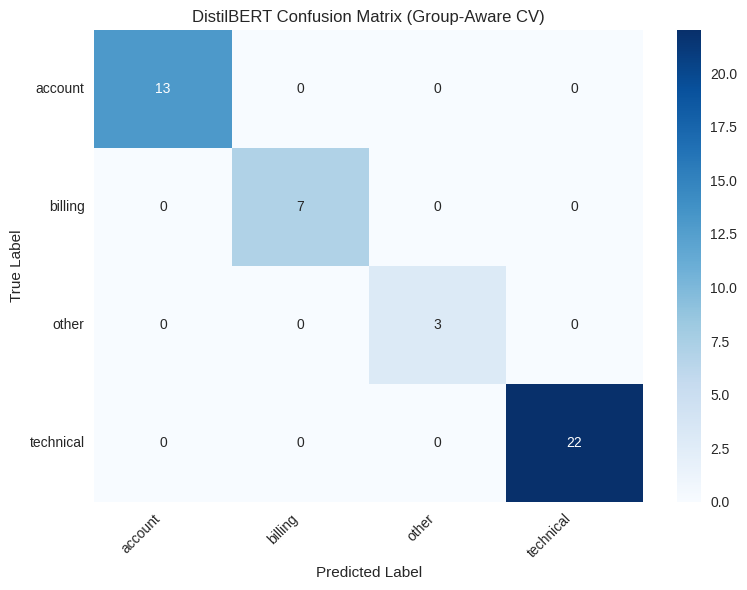

Saved confusion matrix to: ../artifacts/confusion_matrix_test.png

--- Error Analysis ---

Number of misclassified samples: 0
No misclassified samples found in the test set.


In [60]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score

# Start a nested MLflow run for test evaluation
with mlflow.start_run(run_name="DistilBERT Test Evaluation", nested=True):
    mlflow.set_tag("eval_type", "test_set")

    # Examine Test Set Composition
    print("--- Examining Test Set Composition ---")
    print("First 5 samples from the test set:")
    display(test_df.head())
    print("\nValue counts for labels in the test set:")
    display(test_df['label'].value_counts())


    test_loss, test_acc, test_f1_weighted, test_f1_per_class, y_test, y_pred = eval_epoch(test_loader)
    print("\n--- Model Evaluation on Test Set ---")
    print("Test Accuracy:", test_acc)
    print("Test F1 (Weighted):", test_f1_weighted)
    print("Test F1 (Per-Class):", test_f1_per_class) # Print per-class F1
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred, target_names=labels))

    cm = confusion_matrix(y_test, y_pred)

    # Save confusion matrix as artifact
    os.makedirs("../artifacts", exist_ok=True)
    cm_save_path = "../artifacts/confusion_matrix_test.png"
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=labels, yticklabels=labels)
    plt.title("DistilBERT Confusion Matrix (Group-Aware CV)")
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.xticks(rotation=45, ha="right")
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.savefig(cm_save_path)
    plt.show()
    print(f"Saved confusion matrix to: {cm_save_path}")

    # Log confusion matrix to MLflow
    mlflow.log_artifact(cm_save_path, artifact_path="evaluation")

    # Log test metrics
    mlflow_metrics = {"test_loss": test_loss, "test_acc": test_acc, "test_f1_weighted": test_f1_weighted}
    # Log per-class F1 scores for the test set
    for i, label_name in enumerate(labels):
        if i < len(test_f1_per_class):
            mlflow_metrics[f"test_f1_{label_name}"] = test_f1_per_class[i]
        else:
            # Handle cases where a label might not be present in the test set predictions/true labels
            mlflow_metrics[f"test_f1_{label_name}"] = 0.0

    mlflow.log_metrics(mlflow_metrics)

    # Perform Error Analysis
    print("\n--- Error Analysis ---")
    # Create a DataFrame to easily compare true and predicted labels
    results_df = pd.DataFrame({'True Label': [id2label[label] for label in y_test],
                               'Predicted Label': [id2label[pred] for pred in y_pred]})

    # Identify misclassified samples
    misclassified_df = results_df[results_df['True Label'] != results_df['Predicted Label']]

    print(f"\nNumber of misclassified samples: {len(misclassified_df)}")

    if not misclassified_df.empty:
        print("\nExamples of misclassified samples:")
        # Display some misclassified samples from the original test_df
        # Need to align misclassified_df indices with original test_df indices
        misclassified_indices = misclassified_df.index.tolist()
        # Ensure indices are within the bounds of test_df
        valid_misclassified_indices = [idx for idx in misclassified_indices if idx < len(test_df)]
        display(test_df.iloc[valid_misclassified_indices].head()) # Display first 5 misclassified samples from test_df
    else:
        print("No misclassified samples found in the test set.")


## 8. Learning Curves

This section visualizes the training and validation loss and key evaluation metrics (Accuracy and Weighted F1 Score) over the training epochs. These learning curves help in understanding the training progress, identifying potential issues like overfitting, and determining if the model has converged.

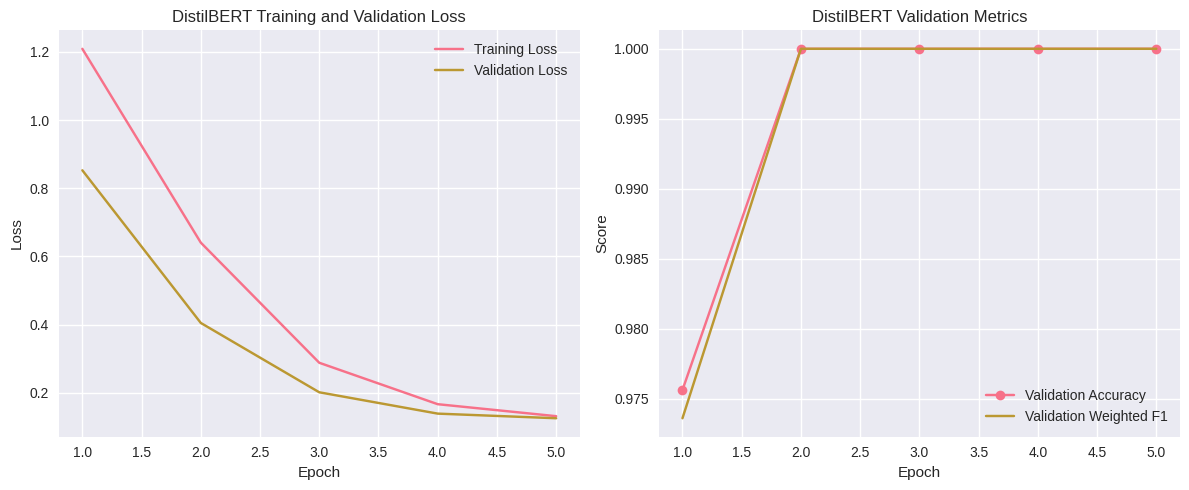

In [61]:
epochs = range(1, len(train_losses) + 1)

# Plot Loss
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs, train_losses, label='Training Loss')
plt.plot(epochs, val_losses, label='Validation Loss')
plt.title('DistilBERT Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

# Plot Accuracy and F1
plt.subplot(1, 2, 2)
plt.plot(epochs, val_accuracies, label='Validation Accuracy', marker='o')
plt.plot(epochs, val_f1_weighted_scores, label='Validation Weighted F1', marker='x')
plt.title('DistilBERT Validation Metrics')
plt.xlabel('Epoch')
plt.ylabel('Score')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

In [62]:
# Defensive: construct `summary_df` if missing using available results/metrics
import numpy as np
import pandas as pd
if 'summary_df' not in globals():
    rows = []
    seen_models = set()
    # Ingest simple `results` DataFrame if present
    if 'results' in globals():
        try:
            r = results.copy()
            # Normalize column names if needed
            if 'model' in r.columns:
                for _, row in r.iterrows():
                    rows.append({
                        'Model': row.get('model') if 'model' in r.index or 'model' in r.keys() else row.get('Model'),
                        'Accuracy': row.get('accuracy') if 'accuracy' in r.index or 'accuracy' in r.keys() else None,
                        'Weighted F1': row.get('weighted_f1') if 'weighted_f1' in r.index or 'weighted_f1' in r.keys() else None,
                        'Macro F1': np.nan,
                        'Per-class F1': None
                    })
                    seen_models.add(rows[-1]['Model'])
        except Exception:
            pass
    # Ingest `metrics` dict if present
    if 'metrics' in globals():
        try:
            for k, v in metrics.items():
                model_name = k.replace('_', ' ').title()
                if model_name in seen_models:
                    continue
                acc = v.get('accuracy') if isinstance(v, dict) else None
                wf1 = v.get('weighted_f1') if isinstance(v, dict) else None
                rows.append({'Model': model_name, 'Accuracy': acc, 'Weighted F1': wf1, 'Macro F1': np.nan, 'Per-class F1': None})
                seen_models.add(model_name)
        except Exception:
            pass
    # Add DistilBERT results if available from evaluation variables
    if 'test_acc' in globals() or 'test_f1_weighted' in globals():
        name = 'distilbert'
        if name not in seen_models:
            acc = globals().get('test_acc', None)
            wf1 = globals().get('test_f1_weighted', None)
            pcf = globals().get('test_f1_per_class', None)
            try:
                macro = float(np.mean(pcf)) if (isinstance(pcf, (list, np.ndarray)) and len(pcf) > 0) else (None if wf1 is None else float(wf1))
            except Exception:
                macro = None
            per_class = None
            try:
                if isinstance(pcf, (list, np.ndarray)) and 'labels' in globals() and len(pcf) == len(labels):
                    per_class = dict(zip(labels, [float(x) for x in pcf]))
            except Exception:
                per_class = None
            rows.append({'Model': name, 'Accuracy': acc, 'Weighted F1': wf1, 'Macro F1': macro, 'Per-class F1': per_class})
            seen_models.add(name)
    # Finalize summary_df
    if rows:
        summary_df = pd.DataFrame(rows)
    else:
        summary_df = pd.DataFrame(columns=['Model','Accuracy','Weighted F1','Macro F1','Per-class F1'])
    print('Constructed summary_df with rows:', len(summary_df))
else:
    print('summary_df already exists with rows:', len(summary_df))

Constructed summary_df with rows: 5


In [63]:






display_cols = ["Model", "Accuracy", "Weighted F1", "Macro F1"]
cmp_df = summary_df[display_cols].copy()

# Ensure numeric
for c in ["Accuracy", "Weighted F1", "Macro F1"]:
    cmp_df[c] = pd.to_numeric(cmp_df[c], errors="coerce")

cmp_df.sort_values(by="Weighted F1", ascending=False, inplace=True)
cmp_df.reset_index(drop=True, inplace=True)
cmp_df


,Model,Accuracy,Weighted F1,Macro F1
0,distilbert,1.000000,1.000000,0.307692
1,Tfidf Logistic Regression,0.778947,0.766271,NaN
2,tfidf_logreg,0.778947,0.766271,NaN
3,majority,0.263158,0.109649,NaN
4,Majority Classifier,0.263158,0.109649,NaN


## 5) Plot bar charts (Accuracy & Weighted F1)

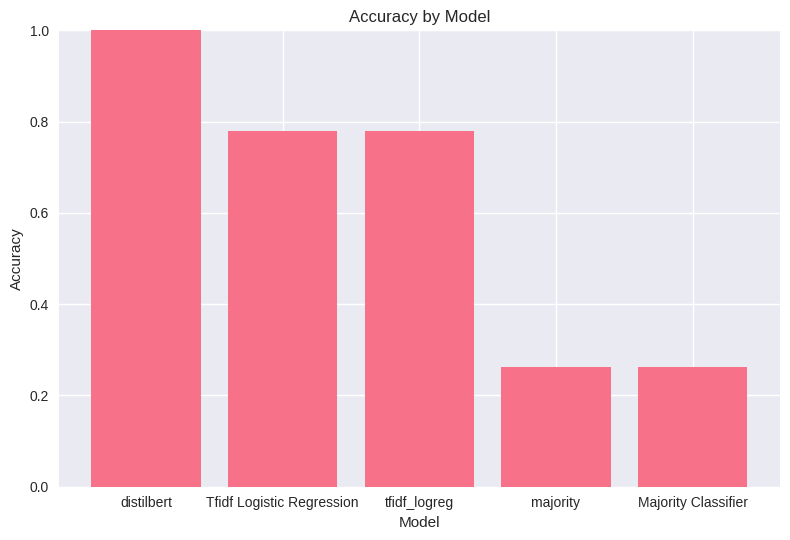

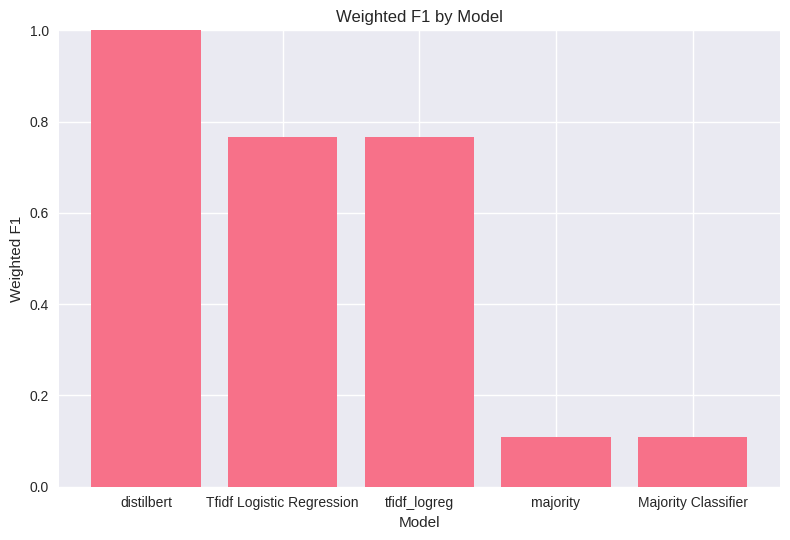

In [64]:

# Accuracy
plt.figure()
plt.bar(cmp_df["Model"], cmp_df["Accuracy"])
plt.title("Accuracy by Model")
plt.ylim(0, 1.0)
plt.xlabel("Model")
plt.ylabel("Accuracy")
plt.tight_layout()
plt.show()

# Weighted F1
plt.figure()
plt.bar(cmp_df["Model"], cmp_df["Weighted F1"])
plt.title("Weighted F1 by Model")
plt.ylim(0, 1.0)
plt.xlabel("Model")
plt.ylabel("Weighted F1")
plt.tight_layout()
plt.show()


## 6)  Per-class F1 breakdown (text view)

In [65]:

for _, row in summary_df.iterrows():
    print("\n=== Per-class (F1) —", row["Model"], "===")
    pc = row["Per-class F1"]
    if isinstance(pc, dict) and pc:
        temp = pd.DataFrame([pc]).T
        temp.columns = ["F1"]
        display(temp.sort_index())
    else:
        print("(no per-class details found in JSON)")



=== Per-class (F1) — majority ===
(no per-class details found in JSON)

=== Per-class (F1) — tfidf_logreg ===
(no per-class details found in JSON)

=== Per-class (F1) — Majority Classifier ===
(no per-class details found in JSON)

=== Per-class (F1) — Tfidf Logistic Regression ===
(no per-class details found in JSON)

=== Per-class (F1) — distilbert ===
(no per-class details found in JSON)


**GRADIO UI AND FASTAPI + FRONTEND**

1.   Mounting of Drive to Colab




In [66]:
# Verify environment and confirm required files will be available
import sys
import os
import subprocess

# Detect if running in Colab
IN_COLAB = 'google.colab' in sys.modules

print(f"Environment: {'Google Colab' if IN_COLAB else 'VSCode/Local'}")

Environment: Google Colab


In [67]:
if IN_COLAB:
    MODEL_DIR = '/content/Thrive_Internship_ML_A/artifacts/models/distilbert/final'
    APP_FILE = '/content/Thrive_Internship_ML_A/app1.py'
    REQUIREMENTS_FILE = '/content/Thrive_Internship_ML_A/requirements.txt'
else:
    MODEL_DIR = os.path.abspath(os.path.join(os.getcwd(), '..', 'artifacts', 'models', 'distilbert', 'final'))
    APP_FILE = os.path.abspath(os.path.join(os.getcwd(), '..', 'api', 'main.py'))
    REQUIREMENTS_FILE = os.path.abspath(os.path.join(os.getcwd(), '..', 'requirements.txt'))

print(f"Model directory: {MODEL_DIR}")
print(f"App file: {APP_FILE}")
print(f"Requirements file: {REQUIREMENTS_FILE}")

Model directory: /content/Thrive_Internship_ML_A/artifacts/models/distilbert/final
App file: /content/Thrive_Internship_ML_A/app1.py
Requirements file: /content/Thrive_Internship_ML_A/requirements.txt


Verify that required files are available for Gradio and FastAPI deployment.

In [68]:
# Verify required files are available
print("🔍 Verifying required files...")
missing = []
for fname, fpath in [('Model', MODEL_DIR), ('App', APP_FILE), ('HTML', HTML_FILE), ('Requirements', REQUIREMENTS_FILE)]:
    if os.path.exists(fpath):
        print(f"✓ {fname} found: {fpath}")
    else:
        print(f"⚠️  {fname} not found: {fpath}")
        missing.append(fname)

if missing:
    if IN_COLAB:
        print(f"\nMissing files: {', '.join(missing)}. Ensure the shared-link downloader cell was executed successfully.")
    else:
        print(f"\nMissing files: {', '.join(missing)}. Ensure you are running from the correct directory or that model files exist.")
else:
    print("\n✓ All required files are available!")

🔍 Verifying required files...
✓ Model found: /content/Thrive_Internship_ML_A/artifacts/models/distilbert/final
✓ App found: /content/Thrive_Internship_ML_A/app1.py
✓ HTML found: /content/Thrive_Internship_ML_A/ClassifAI.html
✓ Requirements found: /content/Thrive_Internship_ML_A/requirements.txt

✓ All required files are available!


Installing requirements dependencies

In [69]:
# Install dependencies
print("📦 Installing dependencies...")

packages = [
    'gradio>=3.41.0',
    'torch>=2.0.0',
    'transformers>=4.30.0',
    'fastapi>=0.100.0',
    'uvicorn[standard]>=0.23.0',
    'pydantic>=2.0.0',
    'pyngrok>=5.1.0',
    'nest-asyncio>=1.5.8',
    'requests>=2.31.0'
]

for package in packages:
    try:
        subprocess.check_call([sys.executable, '-m', 'pip', 'install', '-q', package])
    except subprocess.CalledProcessError as e:
        print(f"⚠️  Failed to install {package}: {e}")

print("✓ Dependencies installed")

📦 Installing dependencies...
✓ Dependencies installed


In [70]:
# Configure ngrok (optional, for Colab public sharing)
if IN_COLAB:
    import os
    from google.colab import userdata

    # Attempt to retrieve NGROK_AUTH_TOKEN from Colab secrets
    # Corrected: remove the default 'None' argument as it causes TypeError
    ngrok_token = userdata.get('NGROK_AUTH_TOKEN')

    if ngrok_token:
        from pyngrok import ngrok as pyngrok_ngrok
        pyngrok_ngrok.set_auth_token(ngrok_token)
        print("✓ ngrok configured with auth token")
    else:
        print("⚠️  NGROK_AUTH_TOKEN not set in Colab secrets. Public tunneling will be unavailable.")
        print("   Please add your ngrok auth token as a Colab secret named 'NGROK_AUTH_TOKEN' to enable.")
else:
    print("✓ VSCode/Local mode - ngrok not needed for local deployment")

✓ ngrok configured with auth token


**The Gradio Interface**

The code allows users to enter a customer support ticket and immediately see all possible categories with their confidence levels, helping support teams quickly route or respond to tickets efficiently

In [71]:
# Install runtime dependencies when running in Colab (idempotent, quiet installs)
import sys, subprocess
if IN_COLAB:
    # Uninstall existing transformers to avoid conflicts
    try:
        print("Uninstalling existing transformers...")
        subprocess.check_call([sys.executable, '-m', 'pip', 'uninstall', '-y', 'transformers'])
        print("Transformers uninstalled.")
    except Exception as e:
        print('Uninstall failed for transformers', e)

    pkgs = [
        'gdown',
        'transformers', # Install latest compatible version
        'torch',
        'gradio',
        'scikit-learn',
        'pandas',
        'tqdm',
        'mlflow',
        'fastapi',
        'uvicorn[standard]'
    ]
    for p in pkgs:
        try:
            print(f"Installing {p}...")
            subprocess.check_call([sys.executable, '-m', 'pip', 'install', '-q', p])
            print(f"Successfully installed {p}")
        except Exception as e:
            print('Install failed for', p, e)
print('Dependency install step complete (or skipped in local mode)')

Uninstalling existing transformers...
Transformers uninstalled.
Installing gdown...
Installing transformers...
Installing torch...
Installing gradio...
Installing scikit-learn...
Installing pandas...
Installing tqdm...
Installing mlflow...
Installing fastapi...
Installing uvicorn[standard]...
Dependency install step complete (or skipped in local mode)


In [72]:
import gradio as gr
import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import os

# Load Model and Tokenizer
print(f"Loading model from: {MODEL_DIR}")

try:
    # Use local_files_only=True to load from local path (avoids HF Hub validation)
    tokenizer = AutoTokenizer.from_pretrained(MODEL_DIR, local_files_only=True)
    model = AutoModelForSequenceClassification.from_pretrained(MODEL_DIR, local_files_only=True)
    model.eval()
    print("✓ Model and tokenizer loaded successfully")
except Exception as e:
    print(f"❌ Error loading model: {e}")
    print(f"   Make sure the model exists at: {MODEL_DIR}")
    raise

# Label Mapping
label_map = {
    0: "account",
    1: "billing",
    2: "other",
    3: "technical"
}

# Prediction Function with Highlighted Top Category
def classify_ticket_text(text):
    """Classify customer support ticket text."""
    if not text.strip():
        return "❌ Error: Please enter valid text."

    try:
        inputs = tokenizer(text, return_tensors="pt", truncation=True, padding=True)
        with torch.no_grad():
            outputs = model(**inputs)

            if hasattr(outputs, 'logits'):
                logits = outputs.logits
                probs = torch.nn.functional.softmax(logits, dim=1)
            else:
                probs = outputs[0]

            # Convert to percentages and clamp
            probs_percentage = [round(min(max(p.item(), 0), 1) * 100, 2) for p in probs[0]]

        # Pair labels with probabilities
        label_probs = [(label_map[i], probs_percentage[i]) for i in range(len(probs_percentage))]
        # Sort by confidence descending
        label_probs.sort(key=lambda x: x[1], reverse=True)

        # Build Markdown string with top category highlighted
        result_lines = []
        for i, (label, prob) in enumerate(label_probs):
            if i == 0:
                # Top predicted category
                result_lines.append(f"✅ **{label}: {prob}%**")
            else:
                result_lines.append(f"- {label}: {prob}%")

        result_markdown = "\n".join(result_lines)
        return result_markdown
    except Exception as e:
        return f"❌ Error during prediction: {str(e)}"

# Gradio Interface
demo = gr.Interface(
    fn=classify_ticket_text,
    inputs=gr.Textbox(lines=3, placeholder="Enter customer ticket text...", label="Ticket Text"),
    outputs=gr.Markdown(label="Category Confidence (%)"),
    title="Customer Support Ticket Classifier",
    description="Enter a customer support ticket and see all possible categories with their confidence levels.",
    examples=[
        ["I can't log into my account"],
        ["My payment failed but I was charged"],
        ["The app keeps crashing after update"],
        ["Just wanted to say thanks for the great support!"]
    ],
    theme="default"
)

# Launch based on environment
if IN_COLAB:
    print("🚀 Launching Gradio in Colab mode...")
    demo.launch(debug=True, share=True)
else:
    print("🚀 Launching Gradio in VSCode mode...")
    print("   Open the URL shown below in your browser")
    demo.launch(debug=False, share=False)

Loading model from: /content/Thrive_Internship_ML_A/artifacts/models/distilbert/final
✓ Model and tokenizer loaded successfully
🚀 Launching Gradio in Colab mode...
Colab notebook detected. This cell will run indefinitely so that you can see errors and logs. To turn off, set debug=False in launch().
* Running on public URL: https://92070a6b44b0c2f1ea.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


Keyboard interruption in main thread... closing server.
Killing tunnel 127.0.0.1:7860 <> https://92070a6b44b0c2f1ea.gradio.live


**Deployment**

This code deploys your FastAPI app temporarily online using ngrok, so external systems (like your HTML page or teammates) can send requests to it — even when running locally or in Google Colab.

In [ ]:
# FastAPI + uvicorn Deployment (optional, runs in background thread)
import threading
import uvicorn
import time
import os
import socket # Added for port checking

# Dynamic content for app1.py to ensure correct MODEL_DIR and robust model loading
app1_content = f"""from fastapi import FastAPI
from fastapi.middleware.cors import CORSMiddleware
from pydantic import BaseModel
from fastapi.responses import FileResponse
import torch
from transformers import DistilBertTokenizerFast, DistilBertForSequenceClassification
from pathlib import Path
import uvicorn

# --- CONFIG ---
id2label = {{
    0: 'account',
    1: 'billing',
    2: 'other',
    3: 'technical'
}}

model_save_path = '{MODEL_DIR}'
device = "cuda" if torch.cuda.is_available() else "cpu"
html_file_path = '{HTML_FILE}'

# --- MODEL LOADING ---
loaded_tokenizer = None
loaded_model = None
last_err = None

# Candidate locations to search for model files (order matters)
candidates = [
    Path('{MODEL_DIR}'),
    Path('{BASE_PATH}') / 'distilbert_ticket_classifier_model',
    Path('{BASE_PATH}') / 'artifacts' / 'models' / 'distilbert_ticket_classifier_model',
    Path('{BASE_PATH}') / 'artifacts' / 'models' / 'distilbert' / 'final',
]

print("Attempting to load model from candidate locations...")
for cand in candidates:
    if cand and cand.exists() and cand.is_dir():
        try:
            print(f"  Trying: {{cand}}")
            loaded_tokenizer = DistilBertTokenizerFast.from_pretrained(str(cand), local_files_only=True)
            loaded_model = DistilBertForSequenceClassification.from_pretrained(str(cand), local_files_only=True)
            loaded_model.to(device)
            loaded_model.eval()
            print(f"  ✓ Successfully loaded model from: {{cand}}")
            break
        except Exception as e:
            last_err = e
            print(f"  ✗ Failed: {{e}}")

if loaded_model is None or loaded_tokenizer is None:
    error_msg = (
        f"Could not load model from local files. Tried: "
        f"{{[str(c) for c in candidates]}}. "
        f"Last error: {{last_err}}"
    )
    print(f"ERROR: {{error_msg}}")
    # Don't raise here; FastAPI will return errors when routes are called

# --- FastAPI APP SETUP ---
app = FastAPI(
    title="Ticket Classification API",
    description="API for classifying customer support tickets",
    version="1.0.0",
)

app.add_middleware(
    CORSMiddleware,
    allow_origins=["*"],
    allow_credentials=True,
    allow_methods=["*"],
    allow_headers=["*"],
)

class TicketText(BaseModel):
    text: str

@app.get("/")
async def root():
    if not Path(html_file_path).exists():
        return {{"error": f"HTML file not found at {{html_file_path}}"}}
    return FileResponse(html_file_path, media_type='text/html')

@app.post("/predict")
async def predict_ticket_class(ticket: TicketText):
    if loaded_model is None or loaded_tokenizer is None:
        return {{"error": "Model not loaded. Please ensure model files are available."}}
    
    try:
        inputs = loaded_tokenizer(ticket.text, return_tensors="pt", truncation=True, padding=True, max_length=256)
        inputs = {{k: v.to(device) for k, v in inputs.items()}}

        with torch.no_grad():
            outputs = loaded_model(**inputs)
            logits = outputs.logits
            probs = torch.nn.functional.softmax(logits, dim=1)

        predicted_label_id = torch.argmax(probs, dim=1).item()
        predicted_label = id2label.get(predicted_label_id, "Unknown")

        all_probs = {{id2label[i]: round(p.item() * 100, 2) for i, p in enumerate(probs[0])}}

        return {{
            "predicted_category": predicted_label,
            "confidence": all_probs[predicted_label],
            "confidences": all_probs
        }}
    except Exception as e:
        return {{"error": f"Prediction failed: {{str(e)}}"}}

if __name__ == "__main__":
    uvicorn.run(app, host="0.0.0.0", port=8000, reload=False)
"""

# Ensure app1.py exists and can be imported
if os.path.exists(APP_FILE):
    # Write the updated content to app1.py
    with open(APP_FILE, 'w') as f:
        f.write(app1_content)

    import importlib.util
    spec = importlib.util.spec_from_file_location("app1", APP_FILE)
    app1 = importlib.util.module_from_spec(spec)
    spec.loader.exec_module(app1)
    app = app1.app
    print("✓ FastAPI app loaded from app1.py")
else:
    print(f"⚠️  app1.py not found at {APP_FILE}")
    print("   Skipping FastAPI deployment")
    app = None

if app:
    print("🚀 Attempting to start FastAPI server in background thread...")

    def start_fastapi_server():
        """Run FastAPI server in background without blocking notebook."""
        try:
            # Try to bind to the port to check if it's in use
            with socket.socket(socket.AF_INET, socket.SOCK_STREAM) as s:
                s.bind(("0.0.0.0", 8000))
            # If bind succeeds, port is free, proceed to run server
            config = uvicorn.Config(app=app, host="0.0.0.0", port=8000, log_level="warning")
            server = uvicorn.Server(config)
            server.run()
        except OSError as e:
            if "address already in use" in str(e):
                print(f"⚠️  Port 8000 is already in use. The FastAPI server may already be running or another process is using the port.")
                print("   Please restart the Colab runtime (Runtime -> Restart runtime...) and re-run cells to ensure a clean start.")
            else:
                print(f"❌ Error starting FastAPI server: {e}")
        except Exception as e:
            print(f"❌ An unexpected error occurred while starting FastAPI server: {e}")

    # Start server in daemon thread (exits when notebook closes)
    server_thread = threading.Thread(target=start_fastapi_server, daemon=True)
    server_thread.start()

    # Small delay to ensure server starts or error is reported
    time.sleep(5) # Increased sleep to allow error message to print if port is in use

    if IN_COLAB:
        from pyngrok import ngrok as pyngrok_ngrok
        # Colab: create ngrok tunnel for public access
        try:
            # Re-check ngrok_token from userdata, as it's the most recent state
            from google.colab import userdata
            ngrok_token = userdata.get('NGROK_AUTH_TOKEN')
            if ngrok_token:
                pyngrok_ngrok.set_auth_token(ngrok_token) # Ensure token is set again just before connect
                # Reuse an existing ngrok tunnel if one already exists to avoid multiple origins.
                try:
                    tunnels = pyngrok_ngrok.get_tunnels()
                except Exception:
                    tunnels = []

                if tunnels:
                    # Use the first existing tunnel's public URL
                    public_url = tunnels[0].public_url
                    print(f"✓ Reusing existing ngrok tunnel: {public_url}")
                else:
                    # Create a new tunnel if none exist
                    ngrok_tunnel = pyngrok_ngrok.connect(8000)
                    public_url = getattr(ngrok_tunnel, 'public_url', None)
                    print(f"✓ Public API URL: {public_url}")
                print(f"   API docs: {public_url}/docs")
            else:
                print("⚠️  NGROK_AUTH_TOKEN not available. Public tunneling will be unavailable.")
                print("   Please ensure your ngrok token is saved correctly in Colab secrets under 'NGROK_AUTH_TOKEN'.")
        except Exception as e:
            print(f"⚠️  ngrok tunnel failed: {e}")
            print("   Please check your ngrok authtoken in Colab secrets (left sidebar -> key icon).")
            print("   Ensure the token is correct and there are no extra spaces or characters.")
    else:
        # VSCode: local access only
        print("✓ FastAPI running locally on http://localhost:8000")
        print("   API docs: http://localhost:8000/docs")

    print("\n📝 Example API call:")
    print('   POST http://localhost:8000/predict')
    print('   {"text": "I cannot login to my account"}')


✓ FastAPI app loaded from app1.py
🚀 Attempting to start FastAPI server in background thread...
❌ Error starting FastAPI server: [Errno 98] Address already in use
✓ Public API URL: https://london-dextrous-lewis.ngrok-free.dev
   API docs: https://london-dextrous-lewis.ngrok-free.dev/docs

📝 Example API call:
   POST http://localhost:8000/predict
   {{"text": "I cannot login to my account"}}


In [ ]:
# Diagnostic: Verify all components are properly connected
import os
from pathlib import Path

print("=" * 70)
print("DEPLOYMENT CONNECTIVITY CHECK")
print("=" * 70)

print("\n✓ 1. File Locations:")
print(f"   BASE_PATH: {BASE_PATH}")
print(f"   APP_FILE: {APP_FILE} (exists: {os.path.exists(APP_FILE)})")
print(f"   HTML_FILE: {HTML_FILE} (exists: {os.path.exists(HTML_FILE)})")
print(f"   MODEL_DIR: {MODEL_DIR} (exists: {os.path.exists(MODEL_DIR)})")

print("\n✓ 2. Repo Files (if available):")
APP_REPO = os.path.join(BASE_PATH, 'api', 'app1.py')
HTML_REPO = os.path.join(BASE_PATH, 'api', 'ClassifAI.html')
print(f"   api/app1.py: {APP_REPO} (exists: {os.path.exists(APP_REPO)})")
print(f"   api/ClassifAI.html: {HTML_REPO} (exists: {os.path.exists(HTML_REPO)})")

print("\n✓ 3. Model Search Paths:")
candidates = [
    Path(MODEL_DIR),
    Path(BASE_PATH) / 'distilbert_ticket_classifier_model',
    Path(BASE_PATH) / 'artifacts' / 'models' / 'distilbert_ticket_classifier_model',
    Path(BASE_PATH) / 'artifacts' / 'models' / 'distilbert' / 'final',
]
model_found = False
for i, cand in enumerate(candidates, 1):
    exists = cand.exists()
    print(f"   [{i}] {cand} (exists: {exists})")
    if exists and not model_found:
        model_found = True
        print(f"       ^ Model will be loaded from this location")

if not model_found:
    print("\n   ⚠️  WARNING: No model directory found. The API will fail to load the model.")
    print("   Please ensure you have downloaded/placed the model in one of the above locations.")

print("\n✓ 4. HTML File Configuration:")
if os.path.exists(HTML_FILE):
    with open(HTML_FILE, 'r', encoding='utf-8', errors='ignore') as f:
        content = f.read()
        if 'window.API_BASE_URL' in content:
            print("   ✓ HTML has dynamic API_BASE_URL variable")
        elif 'ngrok' in content.lower():
            print("   ⚠️  HTML contains hardcoded ngrok URL (will need to be updated at runtime)")
        else:
            print("   ✓ HTML does not have hardcoded API URL (will auto-detect)")
else:
    print(f"   ✗ HTML file not found at {HTML_FILE}")

print("\n✓ 5. Environment Summary:")
print(f"   Environment: {'Google Colab' if IN_COLAB else 'Local/VSCode'}")
if IN_COLAB:
    print(f"   Drive mounted: {DRIVE_MOUNTED}")
    try:
        from google.colab import userdata
        ngrok_token = userdata.get('NGROK_AUTH_TOKEN')
        print(f"   Ngrok token configured: {bool(ngrok_token)}")
    except Exception:
        print(f"   Ngrok token configured: False")

print("\n" + "=" * 70)
print("SUMMARY: All systems", "ready! ✓" if all([
    os.path.exists(APP_FILE),
    os.path.exists(HTML_FILE),
    model_found
]) else "need attention! ⚠️")
print("=" * 70)
